# General instructions for all labs

1. To turn in:
 - this python notebook, filled out (2 pts)
 - a *standalone* PDF report that contains all the plots, and the answers to all the discussion questions (2 pts)

2. Use of ChatGPT / CoPilot / etc:
   - Allowed, but you own everything that is generated
   - This means that any part of the solution can be asked in the quiz. It can be as detailed as "What was the batch size you used in training" or specific as "what exactly does masking do in this case?" Any discussion question is also game for a quiz question.
   - If I find AI usage to be excessive. I can individually drag any of you in for a 1-1 meeting, in which I grill you on your code. If it looks like irresponsible copy/pasting, without proper understanding, I reserve the right to drastically lower your grade, or even submit cases to GGAC for ethical review.
  
3. Use of peer collaboration:
   - In general not allowed. (Discussion / comparing answers is ok, but work on actual coding independently.)
   - Exceptions can be made if you all wrote your own training script, but 1. it takes forever to train or 2. you don't have great compute resources. Then you can share a trained model amongst yourself *and declare it on your pdf*. However, the code for training *still must be written by yourself*
     


## **Lab 1 Overview**

This lab explores how domain-specific training shapes NanoGPT’s internal representations and output behavior. You will train three separate *small* NanoGPT models on distinct, **tiny** corpora (each \~50–200 KB of text):

1. **Shakespeare corpus** – Short subset of public-domain plays.
2. **Wikipedia corpus** – Small scraped/cleaned sample from open Wikipedia dumps.
3. **Math textbook corpus** – Small public-domain math primer or textbook excerpt.

By comparing these models across zero-shot and few-shot settings, you will observe how the same generative architecture adapts its “classification” over the vocabulary depending on the training distribution.


## **Learning Outcomes**

By the end of the lab, students should:

1. Recognize that **generation is token-level classification**, and that domain-specific data shifts the learned classification boundaries.
2. Understand **zero-shot vs. few-shot** generalization in the context of specialized generative models.
3. Interpret **softmax confidence** and detect overconfidence/oversaturation phenomena.
4. Apply **model interpretability tools** (Grad-CAM) to compare how domain training changes token importance.
5. Connect all observations to **overfitting, evaluation metrics, and embeddings**.


## **Part 1 – Training Domain-Specific Models**

* Use the **same small NanoGPT config** (e.g., `n_layer=2`, `n_head=2`, `n_embd=128`, `block_size=64`) for all runs.
* Train on CPU or free Colab GPU — each model should converge in minutes given the small corpora and reduced parameters.
* Monitor:

  * Training loss curves.
  * Qualitative performance of generated samples.

This section mostly requires you to run scripts that are already written. At each step, pay close attention to the comments, as you may be asked about them in the future.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:

import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
!pip install -r /content/drive/MyDrive/DSF/Lab1/requirements.txt

In [4]:
import os, io, zipfile, requests
from pathlib import Path

# Reliable sources:
# - shakespeare: Karpathy's tiny Shakespeare (plain text)
# - wikipedia: https://www.kaggle.com/datasets/ffatty/plain-text-wikipedia-simpleenglish
# - math: https://archive.org/stream/CalculusMadeEasy/Calculus_Made_Easy_Thompson_djvu.txt



# Download and show sample

shakespeare_text = Path(f"/content/drive/MyDrive/DSF/Lab1/shakespeare.txt").read_text(encoding="utf-8", errors="ignore")
math_text = Path(f"/content/drive/MyDrive/DSF/Lab1/math.txt").read_text(encoding="utf-8", errors="ignore")
wikipedia_text = Path(f"/content/drive/MyDrive/DSF/Lab1/wikipedia.txt").read_text(encoding="utf-8", errors="ignore")


In [5]:
# -----------------------------------------
# Prepare dataset for character-level modeling
# -----------------------------------------

import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

class CharDataset(Dataset):
    def __init__(self, text, block_size, stoi=None, itos=None):
        """
        text: The raw text string we want to train on.
        block_size: The length of each training sequence (number of characters).
        stoi, itos: Optional vocab mappings. If provided, reuse them.
        """

        # 1. Build or reuse the vocabulary
        if stoi is None or itos is None:
            # Build from scratch
            self.chars = sorted(list(set(text)))
            self.vocab_size = len(self.chars)
            self.stoi = {ch: i for i, ch in enumerate(self.chars)}
            self.itos = {i: ch for i, ch in enumerate(self.chars)}
        else:
            # Reuse given vocab
            self.stoi = stoi
            self.itos = itos
            self.vocab_size = len(self.stoi)

        # 2. Store sequence length
        self.block_size = block_size

        # 3. Encode dataset into indices
        #    Use .get(ch, 0) so unknown characters map to 0
        self.data = torch.tensor([self.stoi.get(c, 0) for c in text], dtype=torch.long)

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y


block_size = 128
shakespeare_dataset = CharDataset(shakespeare_text, block_size=block_size, stoi=None, itos=None)
math_dataset = CharDataset(math_text, block_size=block_size, stoi=None, itos=None)
wikipedia_dataset = CharDataset(wikipedia_text, block_size=block_size, stoi=None, itos=None)
shakespeare_loader = DataLoader(shakespeare_dataset, batch_size=block_size, shuffle=True)
math_loader = DataLoader(math_dataset, batch_size=block_size, shuffle=True)
wikipedia_loader = DataLoader(wikipedia_dataset, batch_size=block_size, shuffle=True)

In [6]:
print(device)

cpu


In [7]:
print('The length of the shakespeare dataset is : ', len(shakespeare_dataset))
print('The length of the math dataset is : ', len(math_dataset))
print('The length of the wikipedia dataset is : ', len(wikipedia_dataset))

print("The sequence length (block size) is : ", block_size)

print("No of batches (shakespeare): ", len(shakespeare_dataset) // block_size)
print("No of batches (math): ", len(math_dataset) // block_size)
print("No of batches (wikipedia): ", len(wikipedia_dataset) // block_size)


The length of the shakespeare dataset is :  1115266
The length of the math dataset is :  284859
The length of the wikipedia dataset is :  1842248
The sequence length (block size) is :  128
No of batches (shakespeare):  8713
No of batches (math):  2225
No of batches (wikipedia):  14392



## Analysis: Character Frequency Histogram

Visualize the differences in vocabulary and character usage between corpora (`shakespeare`, `wikipedia`, `math`). Do this by creating a histogram of each character's frequency of occurance, for each corpora.
  
Unicode safety

   * Some characters may not render properly in plots or Jupyter.
   * Replace problematic characters with their Unicode code point.
   * Example helper function:

     ```python
     def safe_label(c):
         try:
             c.encode("ascii")  # check if ASCII-printable
             return c
         except UnicodeEncodeError:
             return f"U+{ord(c):04X}"
     ```


   * Generate one histogram for each corpus (`shakespeare`, `wikipedia`, `math`).
   * For each corpus, write **1–2 sentences** describing:

     * Which characters are most common.
     * Any unusual symbols or formatting.
     * How the distributation of the corpus represents a distribution of a more general language model, e.g. one learned by ChatGPT.



In [8]:
def safe_label(c):
    try:
        c.encode("ascii")  # check if ASCII-printable
        return c
    except UnicodeEncodeError:
        return f"U+{ord(c):04X}"

In [9]:
shakespeare_chars = list(set(shakespeare_text))
math_chars = list(set(math_text))
wikipedia_chars = list(set(wikipedia_text))

shakespeare_char_counts = {c: shakespeare_text.count(c) for c in shakespeare_chars}
math_char_counts = {c: math_text.count(c) for c in math_chars}
wikipedia_char_counts = {c: wikipedia_text.count(c) for c in wikipedia_chars}


In [10]:
print(shakespeare_char_counts)
print(math_char_counts)
print(wikipedia_char_counts)


{'r': 48889, 'Q': 231, 'A': 7819, ':': 10316, ',': 19846, 'W': 3530, 'u': 26584, 'E': 6041, 'U': 3313, 'j': 628, 'R': 4869, 's': 49696, 'X': 112, 'w': 17585, 'a': 55507, 'm': 22243, 'S': 4523, 'Y': 1718, 'f': 15770, 'l': 33339, 'e': 94611, 'M': 2840, 'Z': 198, '-': 1897, 'z': 356, 'o': 65798, ' ': 169892, 'x': 529, 'c': 15623, 'L': 3876, 'y': 20448, 'h': 51310, 'b': 11321, '!': 2172, 'd': 31358, 'B': 2761, 'i': 45537, 'g': 13356, 'J': 320, 'G': 2399, 't': 67009, 'p': 10808, 'I': 11832, 'O': 5481, 'V': 798, 'q': 609, 'P': 1641, '$': 1, '3': 27, '?': 2462, '&': 3, 'F': 1797, 'C': 3820, "'": 6187, ';': 3628, 'T': 7015, 'N': 5079, 'D': 2089, 'v': 7793, 'H': 3068, 'k': 7088, '.': 7885, 'n': 48529, '\n': 40000, 'K': 1584}
{'Q': 97, '7': 514, ' ': 56947, 'x': 3378, '<': 109, 'B': 225, 'g': 3259, 'G': 186, 'p': 2838, '|': 68, '3': 886, 'F': 596, 'C': 697, ';': 682, 'D': 408, '¥': 9, 'H': 226, 'k': 563, 'n': 11481, '4': 744, '~': 268, 'r': 9170, '#': 128, 'W': 302, 'X': 247, 'j': 250, '{': 75, 

In [11]:
print("No of. chars in Shakespeare:", len(shakespeare_chars))
print("No of. chars in Math:", len(math_chars))
print("No of. chars in Wikipedia:", len(wikipedia_chars))

No of. chars in Shakespeare: 65
No of. chars in Math: 110
No of. chars in Wikipedia: 292


In [12]:
chars_count_arr = shakespeare_char_counts.items()
math_chars_count_arr = math_char_counts.items()
wikipedia_chars_count_arr = wikipedia_char_counts.items()

chars_count_arr = sorted(chars_count_arr, key=lambda x: x[1], reverse=True)
math_chars_count_arr = sorted(math_chars_count_arr, key=lambda x: x[1], reverse=True)
wikipedia_chars_count_arr = sorted(wikipedia_chars_count_arr, key=lambda x: x[1], reverse=True)

In [13]:
print("Top 5 Characters counts in Shakespeare dataset - ", chars_count_arr[:5])
print("Top 5 Characters counts in Math dataset - ", math_chars_count_arr[:5])
print("Top 5 Characters counts in Wikipedia dataset - ", wikipedia_chars_count_arr[:5])

Top 5 Characters counts in Shakespeare dataset -  [(' ', 169892), ('e', 94611), ('t', 67009), ('o', 65798), ('a', 55507)]
Top 5 Characters counts in Math dataset -  [(' ', 56947), ('e', 20970), ('t', 16304), ('\n', 15130), ('a', 13642)]
Top 5 Characters counts in Wikipedia dataset -  [(' ', 304595), ('e', 179311), ('a', 122140), ('t', 120734), ('o', 105490)]


In [14]:
unusual_chars_in_shakespeare = []
unusual_chars_in_math = []
unusual_chars_in_wikipedia = []

for c in shakespeare_char_counts.keys():
    if len(safe_label(c)) >= 3:
        unusual_chars_in_shakespeare.append(c)

for c in math_char_counts.keys():
    if len(safe_label(c)) >= 3:
        unusual_chars_in_math.append(c)

for c in wikipedia_char_counts.keys():
    if len(safe_label(c)) >= 3:
        unusual_chars_in_wikipedia.append(c)



In [15]:
print(" Unusual Characters in Shakespeare dataset - ", unusual_chars_in_shakespeare)
print(" Unusual Characters in Math dataset - ", unusual_chars_in_math)
print(" Unusual Characters in Wikipedia dataset - ", unusual_chars_in_wikipedia)

 Unusual Characters in Shakespeare dataset -  []
 Unusual Characters in Math dataset -  ['¥', '°', '«', '™', '€', '£', '±', '®', '„', '■', '©', '•', '§', '»', '—']
 Unusual Characters in Wikipedia dataset -  ['ÿ', 'ἄ', 'ā', 'ǔ', 'ĕ', '圆', 'ö', 'ǫ', '→', 'κ', 'ㄘ', 'ū', '區', 'ش', 'É', 'ل', 'ζ', 'ø', 'ê', '万', 'ù', 'ب', '八', 'ˊ', '百', '´', 'ț', '⅟', 'ˈ', 'Γ', 'τ', 'à', '³', 'ἡ', 'λ', 'ł', 'Ö', 'è', 'Ş', 'ˋ', '×', 'θ', '∼', '里', '히', 'ʻ', 'δ', 'Θ', 'ć', '÷', '\xa0', 'υ', 'ˇ', 'ó', 'ε', '大', '♆', 'ǐ', '°', 'æ', 'í', 'ä', '−', '國', 'á', 'ǎ', 'ς', 'Á', 'ι', 'ㄕ', 'Ț', '村', 'ə', 'ώ', '…', 'ㄣ', '中', 'ã', 'é', 'ş', 'ī', '™', 'ʼ', 'ㄑ', 'ò', '℠', 'ü', 'ú', 'ℓ', 'の', '‘', '¹', 'ν', 'ě', 'Μ', '\u200e', 'ç', 'ㄢ', 'ō', '爷', 'ἀ', 'ğ', 'Λ', '€', 'ㄌ', '鎮', 'ñ', 'ه', 'ʿ', 'Æ', 'ô', 'ï', 'ţ', 'ά', '£', 'ı', '縣', '子', 'Ø', '†', 'Å', '“', '±', '⁄', '華', 'η', 'ㄓ', '®', '市', 'ο', 'ŏ', '饺', 'ί', 'φ', '神', 'ㄩ', 'Ș', '鄰', 'ψ', '’', '♄', 'ρ', 'â', 'Ţ', 'ð', 'ج', 'ό', 'ㄨ', 'Ε', 'ر', '姬', '²', 'ἥ', 'ɪ', 'β', '–', 'ì'

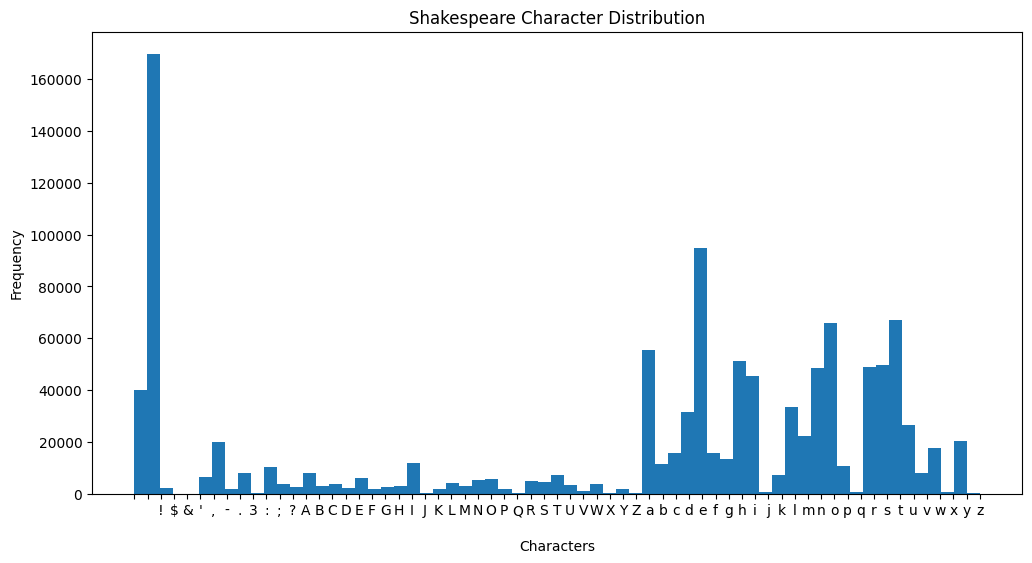

In [16]:
import matplotlib.pyplot as plt

shakespeare_text = sorted(shakespeare_text)
plt.figure(figsize=(12, 6))
plt.hist([safe_label(c) for c in shakespeare_text], bins=len(shakespeare_chars))
plt.title("Shakespeare Character Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


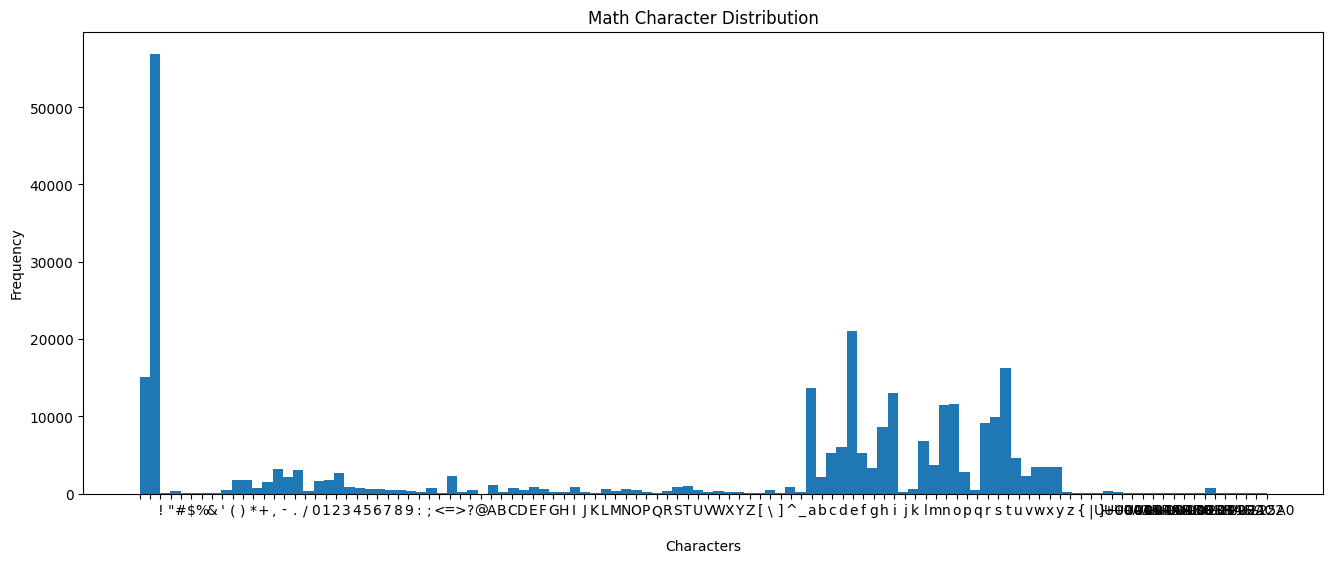

In [16]:
math_text = sorted(math_text)
plt.figure(figsize=(16, 6))
plt.hist([safe_label(c) for c in math_text], bins=len(math_chars))
plt.title("Math Character Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


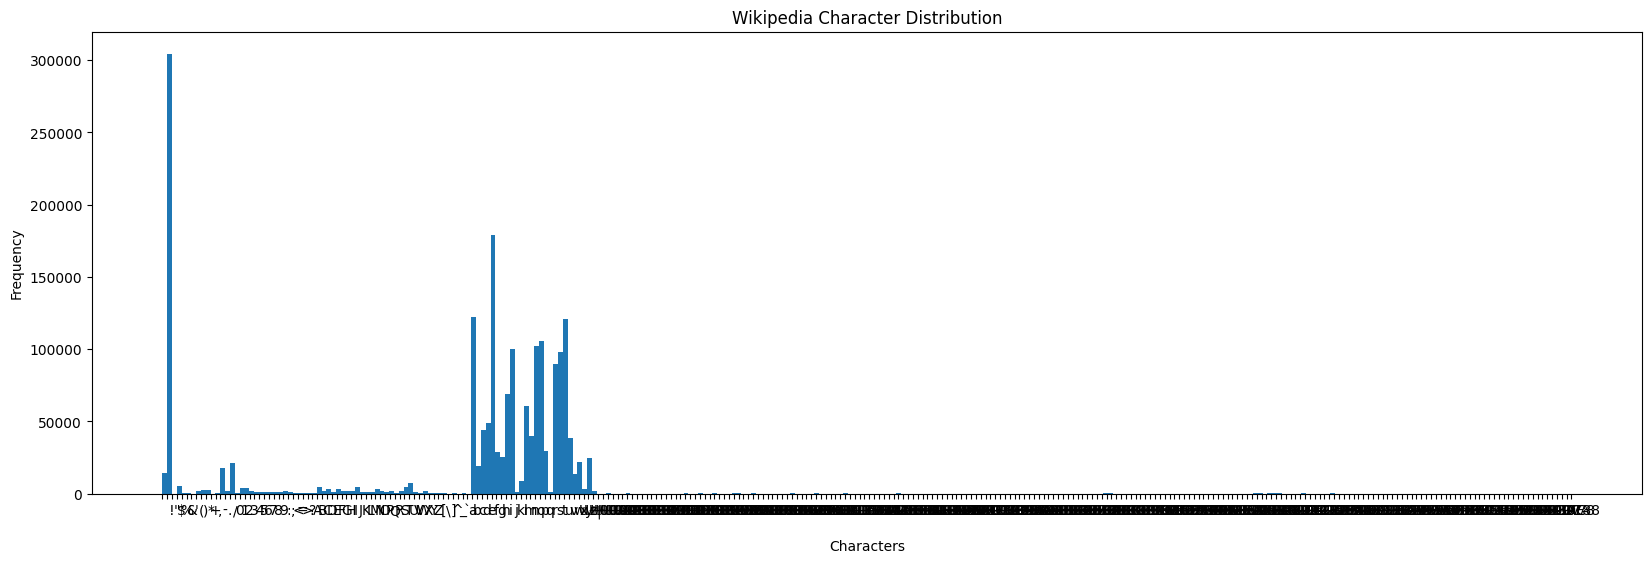

In [17]:
wikipedia_text = sorted(wikipedia_text)
plt.figure(figsize=(20, 6))
plt.hist([safe_label(c) for c in wikipedia_text], bins=len(wikipedia_chars))
plt.title("Wikipedia Character Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


In [12]:
import sys
sys.path.append("/content/drive/MyDrive/DSF/Lab1")
from nanogpt_model import GPT # Import the GPT model class from the NanoGPT repo


# -----------------------------------------
# Define a configuration object for the GPT model
# -----------------------------------------
class GPTConfig:
    def __init__(self, vocab_size, block_size,
                 n_layer=2, n_head=2, n_embd=128, dropout=0.2, bias = True):
        """
        This class is a container for all the key hyperparameters
        that define the size and shape of the GPT model.
        We pass this config into the GPT constructor so the model
        can be built with these exact settings.

        ---------------------------
        Parameter meanings:
        ---------------------------

        vocab_size:
            - Number of unique tokens in our dataset.
            - In a character-level model, this is the number of distinct characters.
            - Maps directly to the size of the token embedding matrix:
                token_embedding_table.shape == (vocab_size, n_embd)

        block_size:
            - Maximum context length (sequence length) the model sees at once.
            - Sets the width of the positional embedding table:
                position_embedding_table.shape == (block_size, n_embd)
            - Also defines the mask size in self-attention so the model only attends
              to the last `block_size` tokens.

        n_layer:
            - Number of Transformer blocks stacked in the model.
            - Each block = (Multi-Head Self-Attention + Feedforward MLP + LayerNorm).
            - More layers allow the model to capture more complex dependencies.

        n_head:
            - Number of attention heads per multi-head attention layer.
            - Each head learns to focus on different positions/tokens in the sequence.
            - Heads are concatenated then projected back into `n_embd` dimensions.

        n_embd:
            - Dimensionality of token embeddings and all hidden states.
            - Controls the "width" of the model.
            - Affects:
                * Token embedding size
                * Positional embedding size
                * Per-head dimension in attention: head_dim = n_embd / n_head
                * Hidden size of the feedforward layers in each block.

        dropout:
            - Dropout probability applied in various places (attention, MLP) during training.
            - Helps prevent overfitting by randomly zeroing activations.

        """

        # Store all parameters for use by the GPT class
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        self.bias = bias


shakespeare_config = GPTConfig(vocab_size=shakespeare_dataset.vocab_size, block_size=block_size)
math_config = GPTConfig(vocab_size=math_dataset.vocab_size, block_size=block_size)
wikipedia_config = GPTConfig(vocab_size=wikipedia_dataset.vocab_size, block_size=block_size)

shakespeare_model = GPT(shakespeare_config)
math_model = GPT(math_config)
math_model.to(device)
wikipedia_model = GPT(wikipedia_config)
wikipedia_model.to(device)
print(shakespeare_model)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 128)
    (wpe): Embedding(128, 128)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=65, bias=Fal

In [19]:
type(shakespeare_config)

__main__.GPTConfig



## Analysis: Model Architecture Diagram

Create a clear, labeled diagram of the NanoGPT model you trained, showing the **flow of data** from input to output, including the **shapes/dimensions** at each stage. Do this *by hand*. You may use a tablet, but it cannot look code-generated.


1. **Overall Layout**

   * Show the full pipeline:
     **Input Tokens → Token Embedding → Positional Embedding → Transformer Blocks → LayerNorm → Output Head → Softmax**.

2. **Transformer Blocks**

   * Each block should include:

     * **LayerNorm 1 → Multi-Head Causal Self-Attention → Residual Connection**
     * **LayerNorm 2 → Feedforward MLP → Residual Connection**
   * Clearly label these sub-components and indicate that this block repeats `n_layer` times.

3. **Dimensions**

   * Label the **shape** of the tensor at each stage (batch size = `B`, sequence length = `T`, embedding size = `n_embd`):

     * Input: `(B, T)` (integer token IDs)
     * Token embeddings: `(B, T, n_embd)`
     * After adding positional embeddings: `(B, T, n_embd)`
     * Inside attention: queries/keys/values → `(B, n_head, T, head_dim)`
     * MLP layers: `(B, T, 4*n_embd)` then back to `(B, T, n_embd)`
     * Output logits: `(B, T, vocab_size)`

4. **Connections**

   * Draw arrows between each component to show the data flow.
   * Mark residual connections that add the block’s input to its output.

5. **Label Hyperparameters**

   * Include:

     * `n_layer` = number of transformer blocks
     * `n_head` = number of attention heads per block
     * `n_embd` = embedding dimension
     * `block_size` = maximum context length
     * `vocab_size` = size of the token vocabulary

6. **Final Output**

   * Show that the model outputs logits for each token position, then a softmax over the vocabulary to get probabilities.






## Training NanoGPT

The following code actually **trains NanoGPT** on your selected dataset.
Your job is to:

1. **Play around with the hyperparameters** (e.g. learning rate, batch size, context length, number of layers).
2. **Run the training loop** long enough to get meaningful results.
3. **Save a trained checkpoint for each of the three corpora** (`shakespeare`, `wikipedia`, `math`).

After training:

* You should have a folder of checkpoints (e.g. `checkpoints/shakespeare/final.pt`).
* Each corpus will give you a slightly different “voice” when you generate text.


In [18]:
def train_model(model, config, dataset, dataloader, no_of_epoch, checkpoint_interval, device, checkpoint_dir, checkpoint_name, iterations, losses, training_losses):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    model.train()
    max_iterations = len(dataloader)
    for it in range(no_of_epoch):
        for i, (xb, yb) in enumerate(dataloader):
          xb = xb.to(device)
          yb = yb.to(device)
          logits, loss = model(xb, yb)
          training_losses.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if iterations % checkpoint_interval == 0:
              # Evaluate on full dataset (avg loss across all batches)
              model.eval()
              eval_losses = []

              max_batches = len(dataloader) * 0.01
              for i, (xb_eval, yb_eval) in enumerate(dataloader):
                  if i >= max_batches:  break
                  xb_eval = xb_eval.to(device)
                  yb_eval = yb_eval.to(device)
                  logits_eval, loss_eval = model(xb_eval, yb_eval)
                  eval_losses.append(loss_eval.item())
              avg_loss = torch.mean(torch.tensor(eval_losses))
              losses.append(avg_loss)
              print(f"Iter {iterations}/{max_iterations}, Avg Loss over dataset: {avg_loss:.4f}")

              # Save periodic checkpoint
              iter_ckpt_path = os.path.join(checkpoint_dir, checkpoint_name + f"iter_{iterations}.pt")
              torch.save({
                  "model_state": model.state_dict(),
                  "config": config.__dict__,
                  "itos": dataset.itos,
                  "stoi": dataset.stoi,
                  "losses": losses,
                  "training_loss": training_losses
              }, iter_ckpt_path)
              print(f"Saved checkpoint: {iter_ckpt_path}")
              model.train()  # back to training mode
          iterations += 1

    final_ckpt_path = os.path.join(checkpoint_dir, checkpoint_name + f"final.pt")
    # Save final checkpoint
    torch.save({
        "model_state": model.state_dict(),
        "config": config.__dict__,
        "itos": dataset.itos,
        "stoi": dataset.stoi,
        "losses": losses,
        "training_loss": training_losses
    }, final_ckpt_path)
    print(f"Saved final model to {final_ckpt_path}")

In [ ]:
import os
os.makedirs("/content/drive/MyDrive/DSF/Lab1/checkpoints", exist_ok=True)
os.makedirs("/content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare", exist_ok=True)
os.makedirs("/content/drive/MyDrive/DSF/Lab1/checkpoints/math", exist_ok=True)
os.makedirs("/content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia", exist_ok=True)

In [ ]:
shakespeare_final_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "shakespeare", "final.pt")
shakespeare_final_ckpt = torch.load(shakespeare_final_ckpt_path, map_location=device)
shakespeare_final_ckpt['config']['vocab_size'] = len(shakespeare_dataset.itos)
shakespeare_config = GPTConfig(**shakespeare_final_ckpt["config"])
shakespeare_model = GPT(shakespeare_config)
shakespeare_model.load_state_dict(shakespeare_final_ckpt["model_state"])
shakespeare_model.to(device)

shakespeare_training_loss = shakespeare_final_ckpt["training_loss"]
shakespeare_losses = shakespeare_final_ckpt["losses"]

number of parameters: 0.41M


In [ ]:
print(type(shakespeare_final_ckpt["config"]))

<class 'dict'>


In [ ]:
train_model(shakespeare_model, shakespeare_config, shakespeare_dataset, shakespeare_loader, 2, 100, device, "/content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare", "", 34801, shakespeare_losses, shakespeare_training_loss)

Iter 34900/17427, Avg Loss over dataset: 1.3944
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare/iter_34900.pt
Iter 35000/17427, Avg Loss over dataset: 1.3904
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare/iter_35000.pt
Iter 35100/17427, Avg Loss over dataset: 1.3908
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare/iter_35100.pt
Iter 35200/17427, Avg Loss over dataset: 1.3906
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare/iter_35200.pt
Iter 35300/17427, Avg Loss over dataset: 1.3901
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare/iter_35300.pt
Iter 35400/17427, Avg Loss over dataset: 1.3924
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare/iter_35400.pt
Iter 35500/17427, Avg Loss over dataset: 1.3905
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare/iter_35500.pt
Iter 35600/17427, Avg Loss over dataset: 1.3925


In [ ]:
train_model(math_model, math_config, math_dataset, math_loader, 16, 100, device, "/content/drive/MyDrive/DSF/Lab1/checkpoints/math", "", 8901, math_losses, math_training_loss)

Iter 9000/2226, Avg Loss over dataset: 1.3130
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_9000.pt
Iter 9100/2226, Avg Loss over dataset: 1.3021
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_9100.pt
Iter 9200/2226, Avg Loss over dataset: 1.3151
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_9200.pt
Iter 9300/2226, Avg Loss over dataset: 1.3083
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_9300.pt
Iter 9400/2226, Avg Loss over dataset: 1.3032
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_9400.pt
Iter 9500/2226, Avg Loss over dataset: 1.3037
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_9500.pt
Iter 9600/2226, Avg Loss over dataset: 1.2931
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_9600.pt
Iter 9700/2226, Avg Loss over dataset: 1.3174
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/math/iter_

In [ ]:
math_final_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "math", "final.pt")
math_final_ckpt = torch.load(math_final_ckpt_path, map_location=device)
math_final_ckpt['config']['vocab_size'] = len(math_dataset.itos)
math_config = GPTConfig(**math_final_ckpt["config"])
math_model = GPT(math_config)
math_model.load_state_dict(math_final_ckpt["model_state"])
math_model.to(device)

math_training_loss = math_final_ckpt["training_loss"]
math_losses = math_final_ckpt["losses"]

number of parameters: 0.41M


In [ ]:
train_model(wikipedia_model, wikipedia_config, wikipedia_dataset, wikipedia_loader, 4, 100, device, "/content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia", "", 0, [], [])

Iter 0/14393, Avg Loss over dataset: 5.1410
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia/iter_0.pt
Iter 100/14393, Avg Loss over dataset: 2.5277
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia/iter_100.pt
Iter 200/14393, Avg Loss over dataset: 2.4485
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia/iter_200.pt
Iter 300/14393, Avg Loss over dataset: 2.3383
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia/iter_300.pt
Iter 400/14393, Avg Loss over dataset: 2.2207
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia/iter_400.pt
Iter 500/14393, Avg Loss over dataset: 2.1148
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia/iter_500.pt
Iter 600/14393, Avg Loss over dataset: 2.0230
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia/iter_600.pt
Iter 700/14393, Avg Loss over dataset: 1.9471
Saved checkpoint: /content/drive/MyDrive/DSF/Lab

## Analysis: Track Model Output Over Training


### **Procedure**
* Extract model checkpoints every **100 iterations** (e.g., `iter_100.pt`, `iter_200.pt`, `iter_300.pt`, …).
* For each corpus (`shakespeare`, `wikipedia`, `math`):
 * Use the provided generation code to produce **one line of generated text** from the **same fixed prompt** (e.g., `"Once upon a time"`).
 * If you find the output has not yet achieved the langauge structure quality you desire, you may want to train it for longer. Go until you have a strong model.

---

### **Consistency**

* Keep the **prompt** identical across all checkpoints, but consistent to the corpora in mind.
* Use the same **number of generated tokens** each time.
* This ensures you can make direct comparisons between outputs.

---

### **Reporting**

In your lab report:

* Include a short **table or list** for each corpus showing:

  * Iteration number.
  * The generated output (first \~100 characters).

* Discuss the following:

  * At what point does the text start to look coherent?
  * How does the style differ between Shakespeare, Wikipedia, and Math?
  * Does the model become **overconfident** (repetitive text, fixed patterns) at later stages?

In [19]:
import os

# This code loads a specific training checkpoint of NanoGPT
# (saved during training) and uses it to generate text.


def generate_small_text(corpus, start_text, iteration_to_load, max_new_tokens):
    # Path to the specific checkpoint

    if iteration_to_load == "final":
        ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", corpus, "final.pt")
    else:
        ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", corpus, f"iter_{iteration_to_load}.pt")

    if not os.path.exists(ckpt_path):
        print(f"Checkpoint {ckpt_path} not found. Make sure to train first.")
        return None
    else:
        # Load checkpoint from disk
        ckpt = torch.load(ckpt_path, map_location="cpu")

        # Rebuild the GPT model from saved config
        loaded_config = type("GPTConfig", (), ckpt["config"])
        gen_model = GPT(loaded_config)
        gen_model.load_state_dict(ckpt["model_state"])
        gen_model.eval()

        # Tokenization: convert characters to IDs
        stoi = ckpt["stoi"]
        itos = ckpt["itos"]
        idx = torch.tensor([stoi.get(c, 0) for c in start_text], dtype=torch.long).unsqueeze(0)

        # Autoregressive generation loop
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Feed only the last block_size tokens
                idx_cond = idx[:, -loaded_config.block_size:]
                logits, _ = gen_model(idx_cond)

                # Convert logits to probabilities
                probs = torch.softmax(logits[:, -1, :], dim=-1)

                # Sample next token from probability distribution
                idx_next = torch.multinomial(probs, num_samples=1)

                # Append new token to the sequence
                idx = torch.cat((idx, idx_next), dim=1)

        # Decode IDs back into text
        generated_text = ''.join([itos[i.item()] for i in idx[0]])
        return generated_text

In [20]:
def get_sample_generated_text(corpus, start_text, iteration_interval, blocksize):
  iterations_no = 0
  generated_text_hm = {}
  while True:
      result = generate_small_text(corpus, start_text, iterations_no, blocksize)
      if result is None:
        break
      generated_text_hm[iterations_no] = result
      iterations_no += iteration_interval
      print(f"Done for iteration - {iterations_no}")
  return generated_text_hm


In [27]:
shakespeare_generated_text_hm = get_sample_generated_text("shakespeare", '''PAULINA:
Good my lords, I pray you lend me ear;
''', 100, block_size)
math_generated_text_hm = get_sample_generated_text("math", "What is the integral of a function having", 100, block_size)
wikipedia_generated_text_hm = get_sample_generated_text("wikipedia", "The history of the modern world can be traced back to", 100, block_size)

number of parameters: 0.41M
Done for iteration - 100
number of parameters: 0.41M
Done for iteration - 200
number of parameters: 0.41M
Done for iteration - 300
number of parameters: 0.41M
Done for iteration - 400
number of parameters: 0.41M
Done for iteration - 500
number of parameters: 0.41M
Done for iteration - 600
number of parameters: 0.41M
Done for iteration - 700
number of parameters: 0.41M
Done for iteration - 800
number of parameters: 0.41M
Done for iteration - 900
number of parameters: 0.41M
Done for iteration - 1000
number of parameters: 0.41M
Done for iteration - 1100
number of parameters: 0.41M
Done for iteration - 1200
number of parameters: 0.41M
Done for iteration - 1300
number of parameters: 0.41M
Done for iteration - 1400
number of parameters: 0.41M
Done for iteration - 1500
number of parameters: 0.41M
Done for iteration - 1600
number of parameters: 0.41M
Done for iteration - 1700
number of parameters: 0.41M
Done for iteration - 1800
number of parameters: 0.41M
Done for 

In [28]:
import pandas as pd

df_shakespeare_sample_generated_text = pd.DataFrame(list(shakespeare_generated_text_hm.items()), columns=['Iteration', 'Text'])
df_math_sample_generated_text = pd.DataFrame(list(math_generated_text_hm.items()), columns=['Iteration', 'Text'])
df_wikipedia_sample_generated_text = pd.DataFrame(list(wikipedia_generated_text_hm.items()), columns=['Iteration', 'Text'])

In [29]:
import json

with open(os.path.join('/content/drive/MyDrive/DSF/Lab1', 'shakespeare_sample_generated_text.json'), 'w') as f:
    json.dump(shakespeare_generated_text_hm, f, indent=2)

with open(os.path.join('/content/drive/MyDrive/DSF/Lab1', 'math_sample_generated_text.json'), 'w') as f:
    json.dump(math_generated_text_hm, f, indent=2)

with open(os.path.join('/content/drive/MyDrive/DSF/Lab1', 'wikipedia_sample_generated_text.json'), 'w') as f:
    json.dump(wikipedia_generated_text_hm, f, indent=2)


In [53]:
import json

with open(os.path.join('/content/drive/MyDrive/DSF/Lab1', 'shakespeare_sample_generated_text.json')) as f:
    data = json.load(f)
df_shakespeare_sample_generated_text = pd.DataFrame(list(data.items()), columns=['Iteration', 'Text'])

with open(os.path.join('/content/drive/MyDrive/DSF/Lab1', 'math_sample_generated_text.json')) as f:
    data = json.load(f)
df_math_sample_generated_text = pd.DataFrame(list(data.items()), columns=['Iteration', 'Text'])

with open(os.path.join('/content/drive/MyDrive/DSF/Lab1', 'wikipedia_sample_generated_text.json')) as f:
    data = json.load(f)
df_wikipedia_sample_generated_text = pd.DataFrame(list(data.items()), columns=['Iteration', 'Text'])

In [54]:
df_shakespeare_sample_generated_text

Iteration  \
0           0   
1         100   
2         200   
3         300   
4         400   
5         500   
6         600   
7         700   
8         800   
9         900   
10       1000   
11       1100   
12       1200   
13       1300   
14       1400   
15       1500   
16       1600   
17       1700   
18       1800   
19       1900   
20       2000   
21       2100   
22       2200   
23       2300   
24       2400   
25       2500   
26       2600   
27       2700   
28       2800   
29       2900   
30       3000   
31       3100   
32       3200   
33       3300   
34       3400   
35       3500   
36       3600   
37       3700   
38       3800   
39       3900   
40       4000   
41       4100   
42       4200   
43       4300   
44       4400   
45       4500   
46       4600   
47       4700   
48       4800   
49       4900   
50       5000   
51       5100   
52       5200   
53       5300   
54       5400   
55       5500   
56       5600   
57       5700   
58       5800   
59       5900   
60       6000   
61       6100   
62       6200   
63       6300   
64       6400   
65       6500   
66       6600   
67       6700   
68       6800   
69       6900   
70       7000   
71       7100   
72       7200   
73       7300   
74       7400   
75       7500   
76       7600   
77       7700   
78       7800   
79       7900   
80       8000   
81       8100   
82       8200   
83       8300   
84       8400   
85       8500   
86       8600   
87       8700   
88       8800   
89       8900   
90       9000   
91       9100   
92       9200   
93       9300   
94       9400   
95       9500   
96       9600   
97       9700   
98       9800   
99       9900   
100     10000   
101     10100   
102     10200   
103     10300   
104     10400   
105     10500   
106     10600   
107     10700   
108     10800   
109     10900   
110     11000   
111     11100   
112     11200   
113     11300   
114     11400   
115     11500   
116     11600   
117     11700   
118     11800   
119     11900   
120     12000   
121     12100   
122     12200   
123     12300   
124     12400   
125     12500   
126     12600   
127     12700   
128     12800   
129     12900   
130     13000   
131     13100   
132     13200   
133     13300   
134     13400   
135     13500   
136     13600   
137     13700   
138     13800   
139     13900   
140     14000   
141     14100   
142     14200   
143     14300   
144     14400   
145     14500   
146     14600   
147     14700   
148     14800   
149     14900   
150     15000   
151     15100   
152     15200   
153     15300   
154     15400   
155     15500   
156     15600   
157     15700   
158     15800   
159     15900   
160     16000   
161     16100   
162     16200   
163     16300   
164     16400   
165     16500   
166     16600   
167     16700   
168     16800   
169     16900   
170     17000   
171     17100   
172     17200   
173     17300   
174     17400   
175     17500   
176     17600   
177     17700   
178     17800   
179     17900   
180     18000   
181     18100   
182     18200   
183     18300   
184     18400   
185     18500   
186     18600   
187     18700   
188     18800   
189     18900   
190     19000   
191     19100   
192     19200   
193     19300   
194     19400   
195     19500   
196     19600   
197     19700   
198     19800   
199     19900   
200     20000   
201     20100   
202     20200   
203     20300   
204     20400   
205     20500   
206     20600   
207     20700   
208     20800   
209     20900   
210     21000   
211     21100   
212     21200   
213     21300   
214     21400   
215     21500   
216     21600   
217     21700   
218     21800   
219     21900   
220     22000   
221     22100   
222     22200   
223     22300   
224     22400   
225     22500   
226     22600   
227     22700   
228     22800   
229     22900   
230     23000   
231     23100   
232     23200   
233     23300   
234     2

In [57]:
df_math_sample_generated_text

Iteration  \
0           0   
1         100   
2         200   
3         300   
4         400   
5         500   
6         600   
7         700   
8         800   
9         900   
10       1000   
11       1100   
12       1200   
13       1300   
14       1400   
15       1500   
16       1600   
17       1700   
18       1800   
19       1900   
20       2000   
21       2100   
22       2200   
23       2300   
24       2400   
25       2500   
26       2600   
27       2700   
28       2800   
29       2900   
30       3000   
31       3100   
32       3200   
33       3300   
34       3400   
35       3500   
36       3600   
37       3700   
38       3800   
39       3900   
40       4000   
41       4100   
42       4200   
43       4300   
44       4400   
45       4500   
46       4600   
47       4700   
48       4800   
49       4900   
50       5000   
51       5100   
52       5200   
53       5300   
54       5400   
55       5500   
56       5600   
57       5700   
58       5800   
59       5900   
60       6000   
61       6100   
62       6200   
63       6300   
64       6400   
65       6500   
66       6600   
67       6700   
68       6800   
69       6900   
70       7000   
71       7100   
72       7200   
73       7300   
74       7400   
75       7500   
76       7600   
77       7700   
78       7800   
79       7900   
80       8000   
81       8100   
82       8200   
83       8300   
84       8400   
85       8500   
86       8600   
87       8700   
88       8800   
89       8900   
90       9000   
91       9100   
92       9200   
93       9300   
94       9400   
95       9500   
96       9600   
97       9700   
98       9800   
99       9900   
100     10000   
101     10100   
102     10200   
103     10300   
104     10400   
105     10500   
106     10600   
107     10700   
108     10800   
109     10900   
110     11000   
111     11100   
112     11200   
113     11300   
114     11400   
115     11500   
116     11600   
117     11700   
118     11800   
119     11900   
120     12000   
121     12100   
122     12200   
123     12300   
124     12400   
125     12500   
126     12600   
127     12700   
128     12800   
129     12900   
130     13000   
131     13100   
132     13200   
133     13300   
134     13400   
135     13500   
136     13600   
137     13700   
138     13800   
139     13900   
140     14000   
141     14100   
142     14200   
143     14300   
144     14400   
145     14500   
146     14600   
147     14700   
148     14800   
149     14900   
150     15000   
151     15100   
152     15200   
153     15300   
154     15400   
155     15500   
156     15600   
157     15700   
158     15800   
159     15900   
160     16000   
161     16100   
162     16200   
163     16300   
164     16400   
165     16500   
166     16600   
167     16700   
168     16800   
169     16900   
170     17000   
171     17100   
172     17200   
173     17300   
174     17400   
175     17500   
176     17600   
177     17700   
178     17800   
179     17900   
180     18000   
181     18100   
182     18200   
183     18300   
184     18400   
185     18500   
186     18600   
187     18700   
188     18800   
189     18900   
190     19000   
191     19100   
192     19200   
193     19300   
194     19400   
195     19500   
196     19600   
197     19700   
198     19800   
199     19900   
200     20000   
201     20100   
202     20200   
203     20300   
204     20400   
205     20500   
206     20600   
207     20700   
208     20800   
209     20900   
210     21000   
211     21100   
212     21200   
213     21300   
214     21400   
215     21500   
216     21600   
217     21700   
218     21800   
219     21900   
220     22000   
221     22100   
222     22200   
223     22300   
224     22400   
225     22500   
226     22600   
227     22700   
228     22800   
229     22900   
230     23000   
231     23100   
232     23200   
233     23300   
234     2

In [58]:
df_wikipedia_sample_generated_text

Iteration  \
0           0   
1         100   
2         200   
3         300   
4         400   
5         500   
6         600   
7         700   
8         800   
9         900   
10       1000   
11       1100   
12       1200   
13       1300   
14       1400   
15       1500   
16       1600   
17       1700   
18       1800   
19       1900   
20       2000   
21       2100   
22       2200   
23       2300   
24       2400   
25       2500   
26       2600   
27       2700   
28       2800   
29       2900   
30       3000   
31       3100   
32       3200   
33       3300   
34       3400   
35       3500   
36       3600   
37       3700   
38       3800   
39       3900   
40       4000   
41       4100   
42       4200   
43       4300   
44       4400   
45       4500   
46       4600   
47       4700   
48       4800   
49       4900   
50       5000   
51       5100   
52       5200   
53       5300   
54       5400   
55       5500   
56       5600   
57       5700   
58       5800   
59       5900   
60       6000   
61       6100   
62       6200   
63       6300   
64       6400   
65       6500   
66       6600   
67       6700   
68       6800   
69       6900   
70       7000   
71       7100   
72       7200   
73       7300   
74       7400   
75       7500   
76       7600   
77       7700   
78       7800   
79       7900   
80       8000   
81       8100   
82       8200   
83       8300   
84       8400   
85       8500   
86       8600   
87       8700   
88       8800   
89       8900   
90       9000   
91       9100   
92       9200   
93       9300   
94       9400   
95       9500   
96       9600   
97       9700   
98       9800   
99       9900   
100     10000   
101     10100   
102     10200   
103     10300   
104     10400   
105     10500   
106     10600   
107     10700   
108     10800   
109     10900   
110     11000   
111     11100   
112     11200   
113     11300   
114     11400   
115     11500   
116     11600   
117     11700   
118     11800   
119     11900   
120     12000   
121     12100   
122     12200   
123     12300   
124     12400   
125     12500   
126     12600   
127     12700   
128     12800   
129     12900   
130     13000   
131     13100   
132     13200   
133     13300   
134     13400   
135     13500   
136     13600   
137     13700   
138     13800   
139     13900   
140     14000   
141     14100   
142     14200   
143     14300   
144     14400   
145     14500   
146     14600   
147     14700   
148     14800   
149     14900   
150     15000   
151     15100   
152     15200   
153     15300   
154     15400   
155     15500   
156     15600   
157     15700   
158     15800   
159     15900   
160     16000   
161     16100   
162     16200   
163     16300   
164     16400   
165     16500   
166     16600   
167     16700   
168     16800   
169     16900   
170     17000   
171     17100   
172     17200   
173     17300   
174     17400   
175     17500   
176     17600   
177     17700   
178     17800   
179     17900   
180     18000   
181     18100   
182     18200   
183     18300   
184     18400   
185     18500   
186     18600   
187     18700   
188     18800   
189     18900   
190     19000   
191     19100   
192     19200   
193     19300   
194     19400   
195     19500   
196     19600   
197     19700   
198     19800   
199     19900   
200     20000   
201     20100   
202     20200   
203     20300   
204     20400   
205     20500   
206     20600   
207     20700   
208     20800   
209     20900   
210     21000   
211     21100   
212     21200   
213     21300   
214     21400   
215     21500   
216     21600   
217     21700   
218     21800   
219     21900   
220     22000   
221     22100   
222     22200   
223     22300   
224     22400   
225     22500   
226     22600   
227     22700   
228     22800   
229     22900   
230     23000   
231     23100   
232     23200   
233     23300   
234     2

## Analysis: Variability of the Final Model

### **Procedure**

* After training, take the **final checkpoint** for each corpus.
* Using the same prompt as before (corpus-consistent), generate **multiple outputs (at least 5)**.
* Each output should use the same number of tokens, so they are directly comparable.

---

### **Consistency**

* Keep the prompt identical across all generations for each corpus.
* Do not change model parameters, only re-run generation.

---

### **Reporting**

In your lab report:

* Include the set of generated outputs from the final model.
* Comment on:

  * The **variance** across outputs: do they differ in interesting ways, or are they repetitive?
  * Whether the variability seems to capture the **style** of the corpus.
  * Whether you are satisfied with the outputs: does it feel like the model “learned” something meaningful?



In [34]:
generated_text_hm = {
    "shakespeare": [],
    "math": [],
    "wikipedia": []
}

shakespeare_prompt = '''PAULINA:
Good my lords, I pray you lend me ear;'''
math_prompt = "What is the integral of a function having"
wikipedia_prompt = "The history of the modern world can be traced back to"

for i in range(10):
    for key in generated_text_hm:
        if key == "shakespeare":
            generated_text = generate_small_text(key, shakespeare_prompt, "final", 128)
            generated_text_hm[key].append(generated_text)
        elif key == "math":
            generated_text = generate_small_text(key, math_prompt, "final", 128)
            generated_text_hm[key].append(generated_text)
        elif key == "wikipedia":
            generated_text = generate_small_text(key, wikipedia_prompt, "final", 128)
            generated_text_hm[key].append(generated_text)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M


In [39]:
print(json.dumps(generated_text_hm, indent=2))

{
  "shakespeare": [
    "PAULINA:\nGood my lords, I pray you lend me ear;\nAnd the liness perish, make pinches\nWhich he vown to bear his head-confiner about.\nSo, no more them, gentlewoman, then, mother ",
    "PAULINA:\nGood my lords, I pray you lend me ear; there's tears great credit it be his coars\nWhich are whose treather the\ncurse tongue, that such a even\nFor 'Lancaster Glouceste",
    "PAULINA:\nGood my lords, I pray you lend me ear;\nForth imprisonmity forth.\n\nProvost:\nWhy, of York,\nAnd becomes him going upon sir, with her loise thee tongue,\nAnd the love, que",
    "PAULINA:\nGood my lords, I pray you lend me ear;\nAnd, myself incling, and mercy my hands:\nRight affect this conside as and their Irelain,\nHave fellow, in heir face; for below.\n",
    "PAULINA:\nGood my lords, I pray you lend me ear;\nFind from you, brother, or informine.\n\nBIONDELLO:\nNo gracious shames be so thereafter and,\nA whom prayers, france's countered\nP",
    "PAULINA:\nGood my lords, I pray 



## **Analysis: Plot Training Loss from Checkpoints**

* Produce **one loss curve plot per corpus** (`shakespeare`, `wikipedia`, `math`).
* Compare and contrast the training behavior across the different corpora.

**What to Comment On**

* Identify which loss values seem to correspond to **qualitatively good performance** (e.g., when the model starts producing coherent, domain-appropriate text).
* Note that the **initial drop in loss** is often not enough: real quality emerges only once the model reaches **very low error**.
* Discuss differences across corpora:

  * Which corpus needed lower loss values before outputs became convincing?
  * Do some domains “sound good” ons for what to hand in)?


In [40]:
shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "shakespeare", "final.pt")
math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "math", "final.pt")
wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "wikipedia", "final.pt")

shakespeare_final_ckpt = torch.load(shakespeare_ckpt_path, map_location=device)
math_final_ckpt = torch.load(math_ckpt_path, map_location=device)
wikipedia_final_ckpt = torch.load(wikipedia_ckpt_path, map_location=device)

shakespeare_training_loss = shakespeare_final_ckpt['training_loss']
math_training_loss = math_final_ckpt['training_loss']
wikipedia_training_loss = wikipedia_final_ckpt['training_loss']

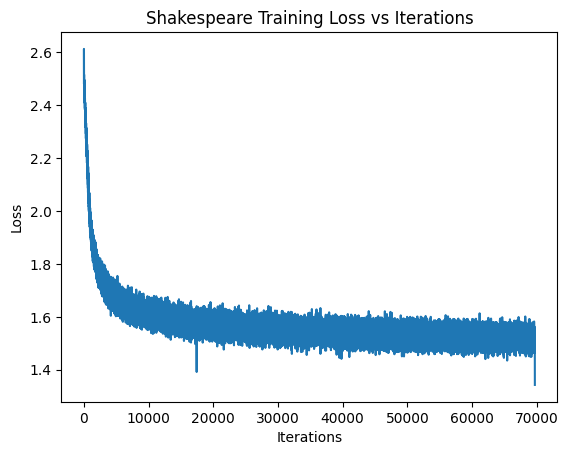

In [41]:
iterations = list(range(1, len(shakespeare_training_loss) + 1))
plt.plot(iterations, shakespeare_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Shakespeare Training Loss vs Iterations')
plt.show()


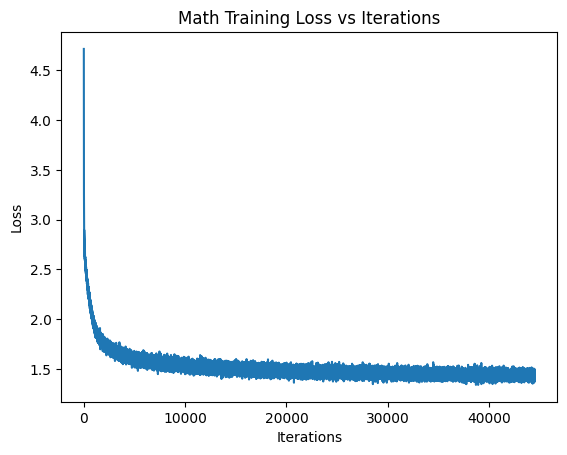

In [42]:
iterations = list(range(1, len(math_training_loss) + 1))
plt.plot(iterations, math_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Math Training Loss vs Iterations')
plt.show()

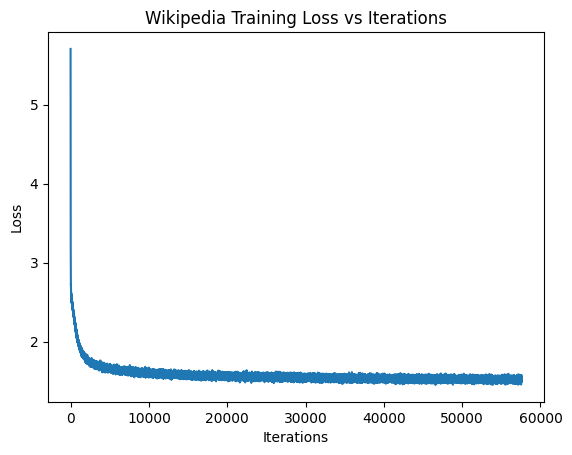

In [43]:
iterations = list(range(1, len(wikipedia_training_loss) + 1))
plt.plot(iterations, wikipedia_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Wikipedia Training Loss vs Iterations')
plt.show()

## **Part 2 – Cross-Domain Evaluation**

* Evaluate each trained model **on each other’s dataset**:

  * **Zero-shot**: Direct prompt without domain examples.
  * **Few-shot**: Include 1–3 in-domain examples in the prompt.
* Compare:

  * Loss in-domain vs. out-of-domain.
  * Quality and relevance of generated continuations.





# Detailed Instructions

### **Part 2 Step 1: Zero-shot Evaluation**

For each dataset pair (A, B) where A, B ∈ {`wikipedia`, `math`, `shakespeare`}:

1. Load the **final checkpoint** of the model trained on A.

   * When rebuilding the model, you must restore the **vocab size** from the checkpoint, e.g.

     ```python
     vocab_size = len(ckpt["stoi"])
     model = GPT(vocab_size=vocab_size)
     ```
   * This ensures the embedding and output layers match the original training.
2. Evaluate it on dataset B **without in-domain examples**. Do so on 1% of the training data, as it is very large.
3. Record the **loss values** in a 3×3 table (diagonal = in-domain).
4. For each pair, include one **generated sample** with these instructions?


In [23]:
def evaluate_model(model, data_loader):
    model.eval()
    losses = []
    max_batches = len(data_loader) * 0.01
    with torch.no_grad():
        for i, (xb, yb) in enumerate(data_loader):
            if i >= max_batches:  break
            xb = xb.to(device)
            yb = yb.to(device)
            logits, loss = model(xb, yb)
            losses.append(loss.item())
    avg_loss = sum(losses) / len(losses) if losses else 0
    print(f"Evaluation Loss: {avg_loss:.4f}")
    return losses, avg_loss

In [26]:
shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "shakespeare", "final.pt")
math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "math", "final.pt")
wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "wikipedia", "final.pt")

shakespeare_final_ckpt = torch.load(shakespeare_ckpt_path, map_location=device)
math_final_ckpt = torch.load(math_ckpt_path, map_location=device)
wikipedia_final_ckpt = torch.load(wikipedia_ckpt_path, map_location=device)

shakespeare_loaded_config = type("GPTConfig", (), shakespeare_final_ckpt["config"])
math_loaded_config = type("GPTConfig", (), math_final_ckpt["config"])
wikipedia_loaded_config = type("GPTConfig", (), wikipedia_final_ckpt["config"])

shakespeare_stoi = shakespeare_final_ckpt["stoi"]
shakespeare_itos = shakespeare_final_ckpt["itos"]

math_stoi = math_final_ckpt["stoi"]
math_itos = math_final_ckpt["itos"]

wikipedia_stoi = wikipedia_final_ckpt["stoi"]
wikipedia_itos = wikipedia_final_ckpt["itos"]

shakespeare_model = GPT(shakespeare_loaded_config)
shakespeare_model.load_state_dict(shakespeare_final_ckpt["model_state"])
shakespeare_model.to(device)

math_model = GPT(math_loaded_config)
math_model.load_state_dict(math_final_ckpt["model_state"])
math_model.to(device)

wikipedia_model = GPT(wikipedia_loaded_config)
wikipedia_model.load_state_dict(wikipedia_final_ckpt["model_state"])
wikipedia_model.to(device)


number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(292, 128)
    (wpe): Embedding(128, 128)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=292, bias=False)
)

In [27]:
shakespeare_text = Path(f"/content/drive/MyDrive/DSF/Lab1/shakespeare.txt").read_text(encoding="utf-8", errors="ignore")
math_text = Path(f"/content/drive/MyDrive/DSF/Lab1/math.txt").read_text(encoding="utf-8", errors="ignore")
wikipedia_text = Path(f"/content/drive/MyDrive/DSF/Lab1/wikipedia.txt").read_text(encoding="utf-8", errors="ignore")

block_size = 64
shakespeare_dataset_for_shakespeare_model = CharDataset(shakespeare_text, block_size=block_size, stoi=shakespeare_stoi, itos=shakespeare_itos)
shakespeare_dataset_for_math_model = CharDataset(shakespeare_text, block_size=block_size, stoi=math_stoi, itos=math_itos)
shakespeare_dataset_for_wikipedia_model = CharDataset(shakespeare_text, block_size=block_size, stoi=wikipedia_stoi, itos=wikipedia_itos)
math_dataset_for_shakespeare_model = CharDataset(math_text, block_size=block_size, stoi=shakespeare_stoi, itos=shakespeare_itos)
math_dataset_for_math_model = CharDataset(math_text, block_size=block_size, stoi=math_stoi, itos=math_itos)
math_dataset_for_wikipedia_model = CharDataset(math_text, block_size=block_size, stoi=wikipedia_stoi, itos=wikipedia_itos)
wikipedia_dataset_for_shakespeare_model = CharDataset(wikipedia_text, block_size=block_size, stoi=shakespeare_stoi, itos=shakespeare_itos)
wikipedia_dataset_for_math_model = CharDataset(wikipedia_text, block_size=block_size, stoi=math_stoi, itos=math_itos)
wikipedia_dataset_for_wikipedia_model = CharDataset(wikipedia_text, block_size=block_size, stoi=wikipedia_stoi, itos=wikipedia_itos)


In [28]:
shakespeare_loader_for_shakespeare_model = DataLoader(shakespeare_dataset_for_shakespeare_model, batch_size=64, shuffle=True)
shakespeare_loader_for_math_model = DataLoader(shakespeare_dataset_for_math_model, batch_size=64, shuffle=True)
shakespeare_loader_for_wikipedia_model = DataLoader(shakespeare_dataset_for_wikipedia_model, batch_size=64, shuffle=True)
math_loader_for_shakespeare_model = DataLoader(math_dataset_for_shakespeare_model, batch_size=64, shuffle=True)
math_loader_for_math_model = DataLoader(math_dataset_for_math_model, batch_size=64, shuffle=True)
math_loader_for_wikipedia_model = DataLoader(math_dataset_for_wikipedia_model, batch_size=64, shuffle=True)
wikipedia_loader_for_shakespeare_model = DataLoader(wikipedia_dataset_for_shakespeare_model, batch_size=64, shuffle=True)
wikipedia_loader_for_math_model = DataLoader(wikipedia_dataset_for_math_model, batch_size=64, shuffle=True)
wikipedia_loader_for_wikipedia_model = DataLoader(wikipedia_dataset_for_wikipedia_model, batch_size=64, shuffle=True)

In [49]:
models = ['shakespeare', 'math', 'wikipedia']
corpus = ['shakespeare', 'math', 'wikipedia']
result = {}
for model_name in models:
    result[model_name] = {}
    for corpus_name in corpus:
        print(f"Evaluating model {model_name} on {corpus_name} corpus")
        if model_name == 'shakespeare':
            model = shakespeare_model
            if corpus_name == 'shakespeare':
                loader = shakespeare_loader_for_shakespeare_model
            elif corpus_name == 'math':
                loader = math_loader_for_shakespeare_model
            else:
                loader = wikipedia_loader_for_shakespeare_model
        elif model_name == 'math':
            model = math_model
            if corpus_name == 'shakespeare':
                loader = shakespeare_loader_for_math_model
            elif corpus_name == 'math':
                loader = math_loader_for_math_model
            else:
                loader = wikipedia_loader_for_math_model
        else:
            model = wikipedia_model
            if corpus_name == 'shakespeare':
                loader = shakespeare_loader_for_wikipedia_model
            elif corpus_name == 'math':
                loader = math_loader_for_wikipedia_model
            else:
                loader = wikipedia_loader_for_wikipedia_model

        losses, avg_loss = evaluate_model(model, loader)
        result[model_name][corpus_name] = {
            "losses": losses,
            "avg_loss": avg_loss
        }
        print(f"Evaluated model {model_name} on {corpus_name} corpus")

Evaluating model shakespeare on shakespeare corpus
Evaluation Loss: 1.3966
Evaluated model shakespeare on shakespeare corpus
Evaluating model shakespeare on math corpus
Evaluation Loss: 3.9497
Evaluated model shakespeare on math corpus
Evaluating model shakespeare on wikipedia corpus
Evaluation Loss: 2.3861
Evaluated model shakespeare on wikipedia corpus
Evaluating model math on shakespeare corpus
Evaluation Loss: 3.2619
Evaluated model math on shakespeare corpus
Evaluating model math on math corpus
Evaluation Loss: 1.2258
Evaluated model math on math corpus
Evaluating model math on wikipedia corpus
Evaluation Loss: 2.5259
Evaluated model math on wikipedia corpus
Evaluating model wikipedia on shakespeare corpus
Evaluation Loss: 2.5144
Evaluated model wikipedia on shakespeare corpus
Evaluating model wikipedia on math corpus
Evaluation Loss: 2.7195
Evaluated model wikipedia on math corpus
Evaluating model wikipedia on wikipedia corpus
Evaluation Loss: 1.3786
Evaluated model wikipedia on 

In [50]:
#save the results
with open("evaluation_results.json", "w") as f:
    json.dump(result, f, indent=2)

### **Part 2 Step 2: Few-shot Evaluation**

1. **Start from a Pretrained Model (Dataset A).**

   * Choose a model that has already been trained on dataset **A** (e.g., `wikipedia`, `math`, `shakespeare`).
   * Load the **final checkpoint** for A:

     ```python
     ckpt_path = f"checkpoints/{A}/final.pt"
     ckpt = torch.load(ckpt_path, map_location="cpu")
     ```
   * Important: the vocabulary size used for training A may differ from the default.

     * Before building the model, set

       ```python
       config.vocab_size = len(ckpt["stoi"])
       model = GPT(config)
       ```
     * This ensures the embedding and output layer dimensions match the checkpoint.
   * Finally, load the weights:

     ```python
     model.load_state_dict(ckpt["model_state"])
     ```

2. **Fine-tune on Dataset B.**

   * Use the **same vocabulary (`stoi`, `itos`) from dataset A** to enco0de dataset B.
   * Train for **200 iterations** with AdamW (`lr=**10, 25, 50, 100, 2ns thereafter if you extend training.
   * Naming convention:

     ```
     {A}_start{N}_{B}_run{M}.pt
     ```

     where

     * **A** = source dataset (e.g. `wikipedia`)
     * **B** = target dataset (e.g. `math`)
     * **N** = starting iteration (e.g. `0` if from scratch, or `500` if resuming)
     * **M** = current fine-tuning iteration

3. **Evaluate and Track Loss.**

   * Every 50 steps, evaluate on a **1% subsample of dataset B** for speed.
   * Record the average evaluation loss.
   * Keep a running list of these evaluation losses to plot later.

4. **Plot Loss Curves.**

   * After training, plot **loss vs iteration** for each experiment.
   * Compare curves across different (A→B) fine-tuning runs.
   * This shows how quickly and effectively each pretrained model adapts to dataset B.

5. **Examples**

   * At each saved checkpoint (10, 25, 50, 100, 200), generate short text continuations from the model.
   * Use the same sampling routine (temperature-controlled decoding).
   * Collect and compare generations to see how quality improves over epochs



In [21]:
def train_model_new(model, config, dataset, dataloader, max_iterations, checkpoint_interval, device, checkpoint_dir, checkpoint_name):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    training_losses = []
    model.train()
    losses = []
    for it in range(max_iterations):
        xb, yb = next(iter(dataloader))
        xb = xb.to(device)
        yb = yb.to(device)
        logits, loss = model(xb, yb)
        training_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % checkpoint_interval == 0 or it == max_iterations - 1:
            # Evaluate on full dataset (avg loss across all batches)
            model.eval()
            eval_losses = []

            max_batches = len(dataloader) * 0.01
            for i, (xb_eval, yb_eval) in enumerate(dataloader):
                if i >= max_batches:  break
                xb_eval = xb_eval.to(device)
                yb_eval = yb_eval.to(device)
                logits_eval, loss_eval = model(xb_eval, yb_eval)
                eval_losses.append(loss_eval.item())
            avg_loss = torch.mean(torch.tensor(eval_losses))
            losses.append(avg_loss)
            print(f"Iter {it}/{max_iterations}, Avg Loss over dataset: {avg_loss:.4f}")

            # Save periodic checkpoint
            iter_ckpt_path = os.path.join(checkpoint_dir, checkpoint_name + f"_run{it}.pt")
            torch.save({
                "model_state": model.state_dict(),
                "config": config.__dict__,
                "itos": dataset.itos,
                "stoi": dataset.stoi,
                "losses": losses,
                "training_loss": training_losses
            }, iter_ckpt_path)
            print(f"Saved checkpoint: {iter_ckpt_path}")
            model.train()  # back to training mode


    final_ckpt_path = os.path.join(checkpoint_dir, checkpoint_name + "_final.pt")
    # Save final checkpoint
    torch.save({
        "model_state": model.state_dict(),
        "config": config.__dict__,
        "itos": dataset.itos,
        "stoi": dataset.stoi,
        "losses": losses,
        "training_loss": training_losses
    }, final_ckpt_path)
    print(f"Saved final model to {final_ckpt_path}")

In [55]:
shakespeare_text = Path(f"/content/drive/MyDrive/DSF/Lab1/shakespeare.txt").read_text(encoding="utf-8", errors="ignore")
math_text = Path(f"/content/drive/MyDrive/DSF/Lab1/math.txt").read_text(encoding="utf-8", errors="ignore")
wikipedia_text = Path(f"/content/drive/MyDrive/DSF/Lab1/wikipedia.txt").read_text(encoding="utf-8", errors="ignore")

shakespeare_dataset_for_shakespeare_model = CharDataset(shakespeare_text, block_size=block_size, stoi=shakespeare_stoi, itos=shakespeare_itos)
shakespeare_dataset_for_math_model = CharDataset(shakespeare_text, block_size=block_size, stoi=math_stoi, itos=math_itos)
shakespeare_dataset_for_wikipedia_model = CharDataset(shakespeare_text, block_size=block_size, stoi=wikipedia_stoi, itos=wikipedia_itos)
math_dataset_for_shakespeare_model = CharDataset(math_text, block_size=block_size, stoi=shakespeare_stoi, itos=shakespeare_itos)
math_dataset_for_math_model = CharDataset(math_text, block_size=block_size, stoi=math_stoi, itos=math_itos)
math_dataset_for_wikipedia_model = CharDataset(math_text, block_size=block_size, stoi=wikipedia_stoi, itos=wikipedia_itos)
wikipedia_dataset_for_shakespeare_model = CharDataset(wikipedia_text, block_size=block_size, stoi=shakespeare_stoi, itos=shakespeare_itos)
wikipedia_dataset_for_math_model = CharDataset(wikipedia_text, block_size=block_size, stoi=math_stoi, itos=math_itos)
wikipedia_dataset_for_wikipedia_model = CharDataset(wikipedia_text, block_size=block_size, stoi=wikipedia_stoi, itos=wikipedia_itos)


shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "shakespeare", "final.pt")
math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "math", "final.pt")
wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "wikipedia", "final.pt")

shakespeare_final_ckpt = torch.load(shakespeare_ckpt_path, map_location=device)
math_final_ckpt = torch.load(math_ckpt_path, map_location=device)
wikipedia_final_ckpt = torch.load(wikipedia_ckpt_path, map_location=device)

shakespeare_loaded_config = GPTConfig(**shakespeare_final_ckpt["config"])
math_loaded_config = GPTConfig(**math_final_ckpt["config"])
wikipedia_loaded_config = GPTConfig(**wikipedia_final_ckpt["config"])

shakespeare_stoi = shakespeare_final_ckpt["stoi"]
shakespeare_itos = shakespeare_final_ckpt["itos"]

math_stoi = math_final_ckpt["stoi"]
math_itos = math_final_ckpt["itos"]

wikipedia_stoi = wikipedia_final_ckpt["stoi"]
wikipedia_itos = wikipedia_final_ckpt["itos"]

shakespeare_model = GPT(shakespeare_loaded_config)
shakespeare_model.load_state_dict(shakespeare_final_ckpt["model_state"])
shakespeare_model.to(device)

math_model = GPT(math_loaded_config)
math_model.load_state_dict(math_final_ckpt["model_state"])
math_model.to(device)

wikipedia_model = GPT(wikipedia_loaded_config)
wikipedia_model.load_state_dict(wikipedia_final_ckpt["model_state"])
wikipedia_model.to(device)

shakespeare_loader_for_shakespeare_model = DataLoader(shakespeare_dataset_for_shakespeare_model, batch_size=64, shuffle=True)
shakespeare_loader_for_math_model = DataLoader(shakespeare_dataset_for_math_model, batch_size=64, shuffle=True)
shakespeare_loader_for_wikipedia_model = DataLoader(shakespeare_dataset_for_wikipedia_model, batch_size=64, shuffle=True)
math_loader_for_shakespeare_model = DataLoader(math_dataset_for_shakespeare_model, batch_size=64, shuffle=True)
math_loader_for_math_model = DataLoader(math_dataset_for_math_model, batch_size=64, shuffle=True)
math_loader_for_wikipedia_model = DataLoader(math_dataset_for_wikipedia_model, batch_size=64, shuffle=True)
wikipedia_loader_for_shakespeare_model = DataLoader(wikipedia_dataset_for_shakespeare_model, batch_size=64, shuffle=True)
wikipedia_loader_for_math_model = DataLoader(wikipedia_dataset_for_math_model, batch_size=64, shuffle=True)
wikipedia_loader_for_wikipedia_model = DataLoader(wikipedia_dataset_for_wikipedia_model, batch_size=64, shuffle=True)

checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-2"
os.makedirs(checkpoint_dir, exist_ok=True)
for model_name in ["shakespeare", "math", "wikipedia"]:
    for corpus_name in ["shakespeare", "math", "wikipedia"]:
        if model_name == corpus_name:
            print(f"Skipping retraining of {model_name} on its own corpus {corpus_name}")
            continue
        inner_checkpoint_dir = os.path.join(checkpoint_dir, f"model-{model_name}_on_corpus-{corpus_name}")
        os.makedirs(inner_checkpoint_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
Skipping retraining of shakespeare on its own corpus shakespeare
Skipping retraining of math on its own corpus math
Skipping retraining of wikipedia on its own corpus wikipedia


In [ ]:
#Train shakespeare model on math dataset for 200 iterations
train_model_new(shakespeare_model, shakespeare_loaded_config, math_dataset_for_shakespeare_model, math_loader_for_shakespeare_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-shakespeare_on_corpus-math"), checkpoint_name="shakespeare_start0_math")
#Train shakespeare model on wikipedia dataset for 200 iterations
train_model_new(shakespeare_model, shakespeare_loaded_config, wikipedia_dataset_for_shakespeare_model, wikipedia_loader_for_shakespeare_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-shakespeare_on_corpus-wikipedia"), checkpoint_name="shakespeare_start0_wikipedia")
#Train math model on shakespeare dataset for 200 iterations
train_model_new(math_model, math_loaded_config, shakespeare_dataset_for_math_model, shakespeare_loader_for_math_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-math_on_corpus-shakespeare"), checkpoint_name="math_start0_shakespeare")
#Train math model on wikipedia dataset for 200 iterations
train_model_new(math_model, math_loaded_config, wikipedia_dataset_for_math_model, wikipedia_loader_for_math_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-math_on_corpus-wikipedia"), checkpoint_name="math_start0_wikipedia")
#Train wikipedia model on shakespeare dataset for 200 iterations
train_model_new(wikipedia_model, wikipedia_loaded_config, shakespeare_dataset_for_wikipedia_model, shakespeare_loader_for_wikipedia_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-wikipedia_on_corpus-shakespeare"), checkpoint_name="wikipedia_start0_shakespeare")
#Train wikipedia model on math dataset for 200 iterations
train_model_new(wikipedia_model, wikipedia_loaded_config, math_dataset_for_wikipedia_model, math_loader_for_wikipedia_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-wikipedia_on_corpus-math"), checkpoint_name="wikipedia_start0_math")

Iter 0/200, Avg Loss over dataset: 3.6417
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-math/shakespeare_start0_math_run0.pt
Iter 50/200, Avg Loss over dataset: 1.7510
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-math/shakespeare_start0_math_run50.pt
Iter 100/200, Avg Loss over dataset: 1.6507
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-math/shakespeare_start0_math_run100.pt
Iter 150/200, Avg Loss over dataset: 1.5962
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-math/shakespeare_start0_math_run150.pt
Iter 199/200, Avg Loss over dataset: 1.5815
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-math/shakespeare_start0_math_run199.pt
Saved final model to /content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-math/shakespeare_start0_math_final.pt
Iter

In [61]:
model_shakespeare_on_math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-2", "model-shakespeare_on_corpus-math", "shakespeare_start0_math_final.pt")
model_shakespeare_on_wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-2", "model-shakespeare_on_corpus-wikipedia", "shakespeare_start0_wikipedia_final.pt")
model_math_on_shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-2", "model-math_on_corpus-shakespeare", "math_start0_shakespeare_final.pt")
model_math_on_wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-2", "model-math_on_corpus-wikipedia", "math_start0_wikipedia_final.pt")
model_wikipedia_on_shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-2", "model-wikipedia_on_corpus-shakespeare", "wikipedia_start0_shakespeare_final.pt")
model_wikipedia_on_math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-2", "model-wikipedia_on_corpus-math", "wikipedia_start0_math_final.pt")

model_shakespeare_on_math_ckpt = torch.load(model_shakespeare_on_math_ckpt_path, map_location=device)
model_shakespeare_on_wikipedia_ckpt = torch.load(model_shakespeare_on_wikipedia_ckpt_path, map_location=device)
model_math_on_shakespeare_ckpt = torch.load(model_math_on_shakespeare_ckpt_path, map_location=device)
model_math_on_wikipedia_ckpt = torch.load(model_math_on_wikipedia_ckpt_path, map_location=device)
model_wikipedia_on_shakespeare_ckpt = torch.load(model_wikipedia_on_shakespeare_ckpt_path, map_location=device)
model_wikipedia_on_math_ckpt = torch.load(model_wikipedia_on_math_ckpt_path, map_location=device)

model_shakespeare_on_math_training_loss = model_shakespeare_on_math_ckpt["losses"]
model_shakespeare_on_wikipedia_training_loss = model_shakespeare_on_wikipedia_ckpt["losses"]
model_math_on_shakespeare_training_loss = model_math_on_shakespeare_ckpt["losses"]
model_math_on_wikipedia_training_loss = model_math_on_wikipedia_ckpt["losses"]
model_wikipedia_on_shakespeare_training_loss = model_wikipedia_on_shakespeare_ckpt["losses"]
model_wikipedia_on_math_training_loss = model_wikipedia_on_math_ckpt["losses"]

In [60]:
len(model_shakespeare_on_math_training_loss)

5

In [27]:
model_shakespeare_on_math_config = type("GPTConfig", (), model_shakespeare_on_math_ckpt["config"])
model_shakespeare_on_math = GPT(model_shakespeare_on_math_config)
model_shakespeare_on_math.load_state_dict(model_shakespeare_on_math_ckpt["model_state"])
model_shakespeare_on_math.to(device)

model_shakespeare_on_wikipedia_config = type("GPTConfig", (), model_shakespeare_on_wikipedia_ckpt["config"])
model_shakespeare_on_wikipedia = GPT(model_shakespeare_on_wikipedia_config)
model_shakespeare_on_wikipedia.load_state_dict(model_shakespeare_on_wikipedia_ckpt["model_state"])
model_shakespeare_on_wikipedia.to(device)

model_math_on_shakespeare_config = type("GPTConfig", (), model_math_on_shakespeare_ckpt["config"])
model_math_on_shakespeare = GPT(model_math_on_shakespeare_config)
model_math_on_shakespeare.load_state_dict(model_math_on_shakespeare_ckpt["model_state"])
model_math_on_shakespeare.to(device)

model_math_on_wikipedia_config = type("GPTConfig", (), model_math_on_wikipedia_ckpt["config"])
model_math_on_wikipedia = GPT(model_math_on_wikipedia_config)
model_math_on_wikipedia.load_state_dict(model_math_on_wikipedia_ckpt["model_state"])
model_math_on_wikipedia.to(device)

model_wikipedia_on_shakespeare_config = type("GPTConfig", (), model_wikipedia_on_shakespeare_ckpt["config"])
model_wikipedia_on_shakespeare = GPT(model_wikipedia_on_shakespeare_config)
model_wikipedia_on_shakespeare.load_state_dict(model_wikipedia_on_shakespeare_ckpt["model_state"])
model_wikipedia_on_shakespeare.to(device)

model_wikipedia_on_math_config = type("GPTConfig", (), model_wikipedia_on_math_ckpt["config"])
model_wikipedia_on_math = GPT(model_wikipedia_on_math_config)
model_wikipedia_on_math.load_state_dict(model_wikipedia_on_math_ckpt["model_state"])
model_wikipedia_on_math.to(device)


number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.43M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(292, 128)
    (wpe): Embedding(128, 128)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=292, bias=False)
)

In [22]:
def generate_small_text_new(model, stoi, itos, start_text, max_new_tokens, block_size):
      idx = torch.tensor([stoi.get(c, 0) for c in start_text], dtype=torch.long).unsqueeze(0)
      model.eval()
      with torch.no_grad():
          for _ in range(max_new_tokens):
              idx_cond = idx[:, -block_size:]
              logits, _ = model(idx_cond)

              probs = torch.softmax(logits[:, -1, :], dim=-1)

              idx_next = torch.multinomial(probs, num_samples=1)

              idx = torch.cat((idx, idx_next), dim=1)

      generated_text = ''.join([itos[i.item()] for i in idx[0]])
      return generated_text

In [41]:
# Math model on shakespeare corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-2/model-math_on_corpus-shakespeare"
prompt = '''PAULINA:
Good my lords, I pray you lend me ear;'''
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"math_start0_shakespeare_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
['PAULINA:\nGood my lords, I pray you lend me ear; \nhence the square is a constant of it order. But \nthey found grown the integration to try. Be acquire able with a \ndecrease at ', "PAULINA:\nGood my lords, I pray you lend me ear;\nHere were those\nknows bath have flundres; how then his unmed the aperat.\n\nX LUS:\nYou as Bookd, ever, whan the height's.\n\nANDARD", "PAULINA:\nGood my lords, I pray you lend me ear;\nHere start hop.\n\nKING RICHARD:\nThere lieken Sows which I certainss, comes am lalget,\nBoth think here?\n\nPEOF And I have made, 't", "PAULINA:\nGood my lords, I pray you lend me ear;\nBut be on a could.\n\nDUKE.\n\nPRORTIO:\nLoves of presemted such signing, thou kool:\nArting much'd from Prach hinks:\nI lord first, t", 'PAULINA:\nGood my lords, I pray you lend me ear;\nAt the saw Of your him: Being dispeak,\nAnd as Him and love\nHu

In [34]:
# Math model on wikipedia corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-2/model-math_on_corpus-wikipedia"
prompt = "The history of the modern world can be traced back to"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"math_start0_wikipedia_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
['The history of the modern world can be traced back to of a Of and in faptory the is stifender,\nWhat this zen, thou the time dies?\nIn a comming the fartt\\ And friends your the poor s', 'The history of the modern world can be traced back to be a 10s. Most costent in cotery, not the way the way does and buck, and king Ruch.\n\nThe dassibtribits is am Laster "forgins.\n\n', 'The history of the modern world can be traced back to destand their like out, Physing, Dust shaped in the deatural has "Prare people changess and object states as its of Giverssing ', 'The history of the modern world can be traced back to use they and mean be days). It is a right mean the first Is Parts, Heir. He Abovathings: Dudingnes from and the centry Cuber ca', 'The history of the modern world can be traced back to loground. Sue them also the iflus radium let zerns are of

In [35]:
# Shakespeare model on math corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-math"
prompt = "What is the integral of a function having"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"shakespeare_start0_math_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
["What is the integral of a function having told;\nThink for that I sword myself?\n\nBIANCA:\nAs if thou go we say 't!'\n\nNurse:\nWhich he world yielded the father's my frame,\nW", "What is the integral of a function having vanue of \n\n\n \n\n,\n\n\n\np\n\n\nf \n  3 \n  praction's coses \ndx\n \n\n\n\n\nDOMORTAS\nThing \n, this aid to the curved of that the ca artentiati", 'What is the integral of a function having to a\nso fill force of the irster r appears of the viri \n\n\n\non\nvv\n\n \n\ndw\n\n J\n\n \n\n-\nDiserate of ; here get us will be you differe', 'What is the integral of a function having \ndy\n-above \n\nv \nx\n\n \n. But, \n\n \n \n-\n\n\n\n\nxIx.\n\n\n\n\nPECESS MADE EASY \nAXIME EASY \n-\n. ON OF EASY .  Fig. \nSo be meirity, and be to', 'What is the integral of a function having sometimes is so values as mean curve to with the q

In [37]:
# Shakespeare model on wikipedia corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-2/model-shakespeare_on_corpus-wikipedia"
prompt = "The history of the modern world can be traced back to"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"shakespeare_start0_wikipedia_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
['The history of the modern world can be traced back to the solution works of work how expression to peparate of \nCan find be velocity, such the great. Which zound is at exprection. \n', 'The history of the modern world can be traced back to to known. In means the which that the in the City of Aprepent. It is in a is the sigartic means into a paxe it is means the cil', 'The history of the modern world can be traced back to house to Kate with Revery a mouth the very contents. From the choligians, as see point of the Catten busings kings to Lesoning ', 'The history of the modern world can be traced back to cally are Irrords, also are and which because the uning proceased inverged it is name. Most Spacid now Weally planu, pritudiage', 'The history of the modern world can be traced back to make written, what imports metrons through used not squaking n

In [38]:
# Wikipedia model on math corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-2/model-wikipedia_on_corpus-math"
prompt = "What is the integral of a function having"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"wikipedia_start0_math_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
["What is the integral of a function havings had we sheet.\n\nCOSIO:\nMe the instors that was seelesh, who great more sick'd is come of Scienties of the righ,\nhowers, or ammo", 'What is the integral of a function havinging also as? This calcular a for of such of y = 2 but \n\n 5) \n\nthen all marve be foaling \n\n\n\nCan make of x+divided \n\n\ndy = dx, OF', 'What is the integral of a function having. \n\n\nAnd \n(1= 18) \n\n\nLet = 7) * 4.w, out the dx = 0d 2 e = 2 =1 = b x= 1 = W the overoing of \nforce \n\ncase would make that and t', 'What is the integral of a function having of the trought the charged maximum is increasing expression of a wealth the weigure, where dy \n\n\n\n\nElement EMGREGRALIPH \n\n\n\n(sc', 'What is the integral of a function having accuration we given y = 3) \n\n\n\n\nDifferentiate of the minutientiate = 2 \n(7)2e) \n\nT

In [39]:
# Wikipedia model on shakespeare corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-2/model-wikipedia_on_corpus-shakespeare"
prompt = '''PAULINA:
Good my lords, I pray you lend me ear;'''
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"wikipedia_start0_shakespeare_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
["PAULINA:\nGood my lords, I pray you lend me ear; the might-slight, in a lime, receiver 901 world's out to find religions or for the milky individua.\n\nThe Europeans are possible", 'PAULINA:\nGood my lords, I pray you lend me ear; I have the sick, is with do will Medition the tree. They than the Romen Iême she GLOS:\nAll grace bloodny, he fick me.\nWe the de', 'PAULINA:\nGood my lords, I pray you lend me ear; How of the time hers of Chonce.\n\nNOIO:\nNo poers brone in the queen so a night\nFoots offend not,\nIf my to "To very high,\nI in he', 'PAULINA:\nGood my lords, I pray you lend me ear; sweet me lord?\n\nShall hote have in the place,\nLive me your my shall be me velock\nThinks you time I arpares.\n\nONINIUS:\nHe preven', 'PAULINA:\nGood my lords, I pray you lend me ear;\nHow say well you break sayling\nIntellow,\nAnd know so it he orthery, w

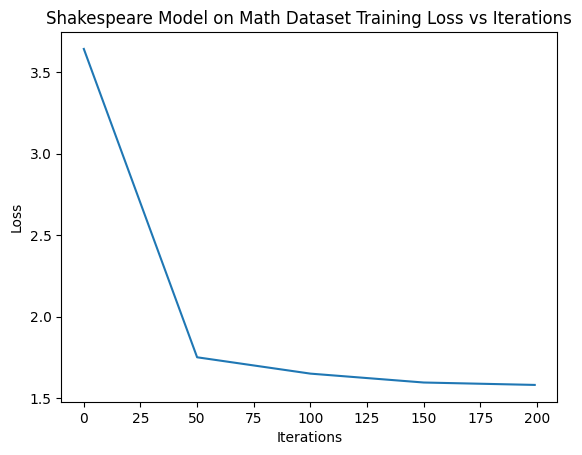

In [62]:
iterations = [0, 50, 100, 150, 199]
plt.plot(iterations, model_shakespeare_on_math_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Shakespeare Model on Math Dataset Training Loss vs Iterations')
plt.show()

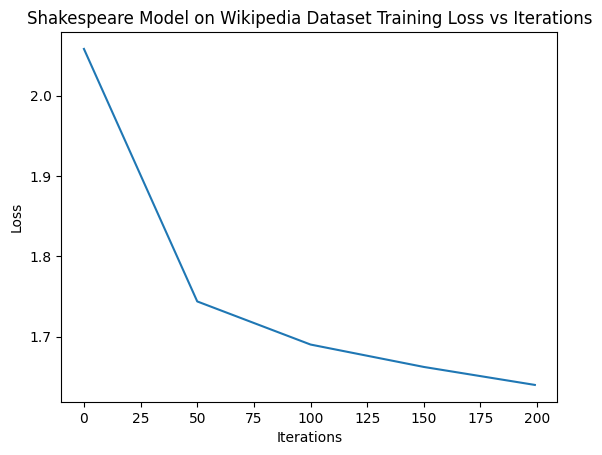

In [63]:
iterations = [0, 50, 100, 150, 199]
plt.plot(iterations, model_shakespeare_on_wikipedia_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Shakespeare Model on Wikipedia Dataset Training Loss vs Iterations')
plt.show()

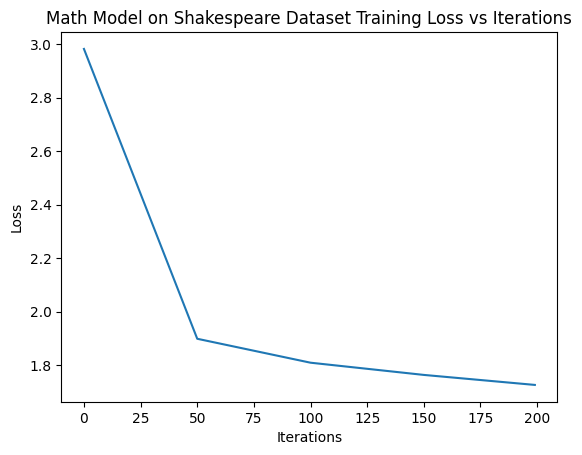

In [64]:
iterations = [0, 50, 100, 150, 199]
plt.plot(iterations, model_math_on_shakespeare_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Math Model on Shakespeare Dataset Training Loss vs Iterations')
plt.show()

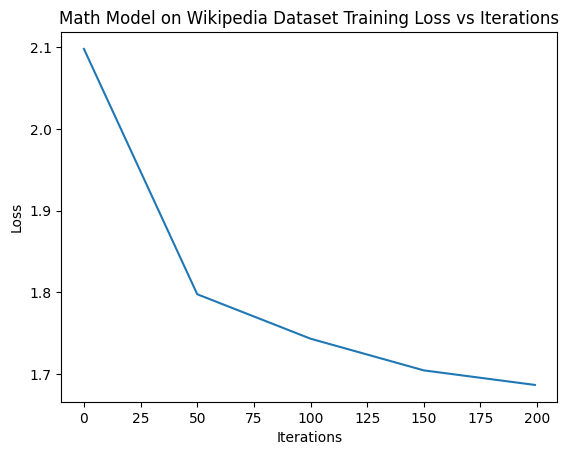

In [65]:
iterations = [0, 50, 100, 150, 199]
plt.plot(iterations, model_math_on_wikipedia_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Math Model on Wikipedia Dataset Training Loss vs Iterations')
plt.show()

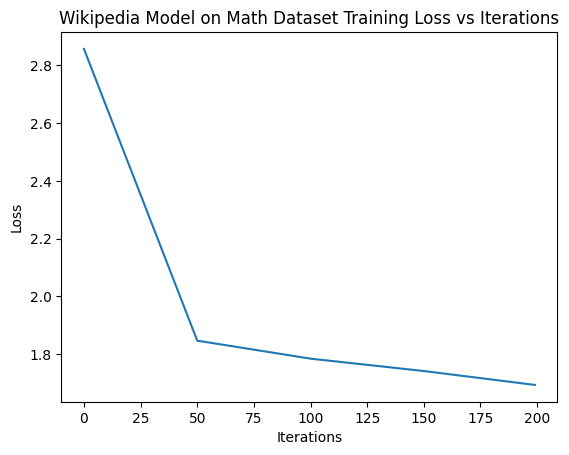

In [66]:
iterations = [0, 50, 100, 150, 199]
plt.plot(iterations, model_wikipedia_on_math_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Wikipedia Model on Math Dataset Training Loss vs Iterations')
plt.show()

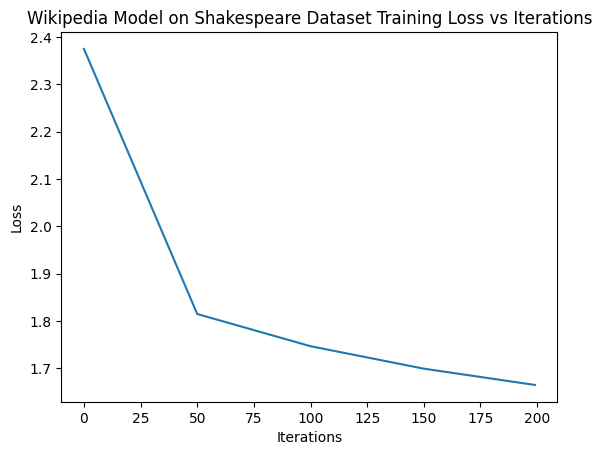

In [67]:
iterations = [0, 50, 100, 150, 199]
plt.plot(iterations, model_wikipedia_on_shakespeare_training_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Wikipedia Model on Shakespeare Dataset Training Loss vs Iterations')
plt.show()

## **Part 2 Step 3: Few-shot from Earlier Checkpoints**

* Repeat Step 2, but start from models that were **not fully trained** on A.
* Compare results: does partial training make adaptation easier?

### **Deliverables**

* **Tables**: Zero-shot loss values (3×3).
* **Plots**: Few-shot loss curves (per experiment).
* **Samples**: Generated text at selected iterations.
* **Discussion**: Briefly how to structure their zero-shot results?


In [67]:
shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "shakespeare", "iter_15000.pt")
math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "math", "iter_8000.pt")
wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/checkpoints", "wikipedia", "iter_8000.pt")

shakespeare_ckpt = torch.load(shakespeare_ckpt_path, map_location=device)
math_ckpt = torch.load(math_ckpt_path, map_location=device)
wikipedia_ckpt = torch.load(wikipedia_ckpt_path, map_location=device)

shakespeare_loaded_config = GPTConfig(**shakespeare_ckpt["config"])
math_loaded_config = GPTConfig(**math_ckpt["config"])
wikipedia_loaded_config = GPTConfig(**wikipedia_ckpt["config"])

shakespeare_stoi = shakespeare_ckpt["stoi"]
shakespeare_itos = shakespeare_ckpt["itos"]

math_stoi = math_ckpt["stoi"]
math_itos = math_ckpt["itos"]

wikipedia_stoi = wikipedia_ckpt["stoi"]
wikipedia_itos = wikipedia_ckpt["itos"]

shakespeare_model = GPT(shakespeare_loaded_config)
shakespeare_model.load_state_dict(shakespeare_ckpt["model_state"])
shakespeare_model.to(device)

math_model = GPT(math_loaded_config)
math_model.load_state_dict(math_ckpt["model_state"])
math_model.to(device)

wikipedia_model = GPT(wikipedia_loaded_config)
wikipedia_model.load_state_dict(wikipedia_ckpt["model_state"])
wikipedia_model.to(device)

checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-3"
os.makedirs(checkpoint_dir, exist_ok=True)
for model_name in ["shakespeare", "math", "wikipedia"]:
    for corpus_name in ["shakespeare", "math", "wikipedia"]:
        if model_name == corpus_name:
            print(f"Skipping retraining of {model_name} on its own corpus {corpus_name}")
            continue
        inner_checkpoint_dir = os.path.join(checkpoint_dir, f"model-{model_name}_on_corpus-{corpus_name}")
        os.makedirs(inner_checkpoint_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
Skipping retraining of shakespeare on its own corpus shakespeare
Skipping retraining of math on its own corpus math
Skipping retraining of wikipedia on its own corpus wikipedia


In [69]:
#Train shakespeare model on math dataset for 200 iterations
train_model_new(shakespeare_model, shakespeare_loaded_config, math_dataset_for_shakespeare_model, math_loader_for_shakespeare_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-shakespeare_on_corpus-math"), checkpoint_name="shakespeare_start0_math")
#Train shakespeare model on wikipedia dataset for 200 iterations
train_model_new(shakespeare_model, shakespeare_loaded_config, wikipedia_dataset_for_shakespeare_model, wikipedia_loader_for_shakespeare_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-shakespeare_on_corpus-wikipedia"), checkpoint_name="shakespeare_start0_wikipedia")
#Train math model on shakespeare dataset for 200 iterations
train_model_new(math_model, math_loaded_config, shakespeare_dataset_for_math_model, shakespeare_loader_for_math_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-math_on_corpus-shakespeare"), checkpoint_name="math_start0_shakespeare")
#Train math model on wikipedia dataset for 200 iterations
train_model_new(math_model, math_loaded_config, wikipedia_dataset_for_math_model, wikipedia_loader_for_math_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-math_on_corpus-wikipedia"), checkpoint_name="math_start0_wikipedia")
#Train wikipedia model on shakespeare dataset for 200 iterations
train_model_new(wikipedia_model, wikipedia_loaded_config, shakespeare_dataset_for_wikipedia_model, shakespeare_loader_for_wikipedia_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-wikipedia_on_corpus-shakespeare"), checkpoint_name="wikipedia_start0_shakespeare")
#Train wikipedia model on math dataset for 200 iterations
train_model_new(wikipedia_model, wikipedia_loaded_config, math_dataset_for_wikipedia_model, math_loader_for_wikipedia_model, max_iterations=200, checkpoint_interval=50, device=device, checkpoint_dir=os.path.join(checkpoint_dir, "model-wikipedia_on_corpus-math"), checkpoint_name="wikipedia_start0_math")

Iter 0/200, Avg Loss over dataset: 3.2611
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-math/shakespeare_start0_math_run0.pt
Iter 50/200, Avg Loss over dataset: 1.7136
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-math/shakespeare_start0_math_run50.pt
Iter 100/200, Avg Loss over dataset: 1.6466
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-math/shakespeare_start0_math_run100.pt
Iter 150/200, Avg Loss over dataset: 1.5858
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-math/shakespeare_start0_math_run150.pt
Iter 199/200, Avg Loss over dataset: 1.5560
Saved checkpoint: /content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-math/shakespeare_start0_math_run199.pt
Saved final model to /content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-math/shakespeare_start0_math_final.pt
Iter

In [42]:
# Math model on shakespeare corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-3/model-math_on_corpus-shakespeare"
prompt = '''PAULINA:
Good my lords, I pray you lend me ear;'''
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"math_start0_shakespeare_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
['PAULINA:\nGood my lords, I pray you lend me ear; but if, then other one grows that of course In to (what he oppece the square toints \nother will be valued as the relation of th', "PAULINA:\nGood my lords, I pray you lend me ear;\nThy hard.\nRARCEIN:\nAre them.\nROLIZ:\nHen worn, etch fatet.\nMy lord soven and lord; at and the couse his in wis''d, you thou have", 'PAULINA:\nGood my lords, I pray you lend me ear;\nBut alk have-thhis bholemumed me!\n\nNUBETHHALLO:\nWhat peropen:\nCoshe all a brout unot substeed, and fore lreader Them,\nBut Sir, ', "PAULINA:\nGood my lords, I pray you lend me ear;\nWhich ranger'ds gamet Crome,\nPaking myself good, and noble, scall must and you Did I'll every!\nIF XELARD The broker somes:\nConc", 'PAULINA:\nGood my lords, I pray you lend me ear;\nBut son, I would me sould: they cared.\n\nDUKE VI:\nO how stank him giv

In [44]:
# Math model on wikipedia corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-3/model-math_on_corpus-wikipedia"
prompt = "The history of the modern world can be traced back to"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"math_start0_wikipedia_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
["The history of the modern world can be traced back to heard; death tangel where hence in the rand is dermc'd of I grow you art must I will may tell ungly goods,\nWhence littlexeives ", 'The history of the modern world can be traced back to which high peristances, as a pople. The Englifice into In From the cirthers.\n\nMistries like as differention and "diam minounati', 'The history of the modern world can be traced back to the people worlds and daya, side is from geoples ups no relived a mont of x in Alwas" the averations by the distand billions.\n\n', 'The history of the modern world can be traced back to might fish a hout of hurlands, in Charge electron, and oldinia, a the unitic bank of countriely IMputled has diakact milion fou', 'The history of the modern world can be traced back to Greek comminus, begands\' come they "Chest the extral, on h

In [45]:
# Shakespeare model on math corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-math"
prompt = "What is the integral of a function having"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"shakespeare_start0_math_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
["What is the integral of a function having of thou thus sweets?\n\nKING RICHARD III:\nWere a whom under me me?\n\nQUEEN ELIZABETH:\n'Tis but lier courter death:\nPetty being hea", 'What is the integral of a function having of the value of of mision \nor \n\n\n \n\n\n\n \n\n \nT\n\n\n n.t\nPAULINATE \n\n \n\n\n\n \n\n \n\n\ni., \n sin. 3N\n.\n3\nJlADY FINTIGTE DWARD \nATEARD FERD', 'What is the integral of a function having Heighbout, thou would x \n\n \n\n-\n\n The first get one second to perse the ; \nthe earing other \n\nTegrow the processions equarrely  ', 'What is the integral of a function having difFerentiating at the inmercider how part of the integrations of her we get on thee ord, and which that defenction by \n\nof y \n', 'What is the integral of a function having, and that the dependy the degreet by values. \n\nThe does to one gown he s

In [46]:
# Shakespeare model on wikipedia corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-3/model-shakespeare_on_corpus-wikipedia"
prompt = "The history of the modern world can be traced back to"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"shakespeare_start0_wikipedia_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
['The history of the modern world can be traced back to-breas. Hence is qually. \n\niefence isservections of the point this deads, compalocity of the more of nuble indefinity regulars \n', 'The history of the modern world can be traced back to an feury\n excember and in the pouncers\ngrowten in of a moder parkes Feorth Berton . \nLandagonethank and get secal being them dr', 'The history of the modern world can be traced back to because first gold \nway. Kole.\n\nIn in a note cases all fou called in makes be the town aven has knows it is percountricks. He w', 'The history of the modern world can be traced back to sometime\n after fails use common lives for world to were the God Spaneral because Marter first discoverional. The life ote the ', 'The history of the modern world can be traced back to leanning the suve alcopic are the last no dry are of J

In [47]:
# Wikipedia model on math corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-3/model-wikipedia_on_corpus-math"
prompt = "What is the integral of a function having"
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"wikipedia_start0_math_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
['What is the integral of a function having beople any it be potes me sbeak old with flow my advant in the part him forthee to face in the heabout trought on the tease wor', 'What is the integral of a function having a farther, \n\n\nsunce alume\nto way it was snown in of the to function and other, \n\n\n\nDye \nY = 2(79557—7), \nWe \n\n\nwhich the curve ', 'What is the integral of a function having. Which we leasys to can be 10) is a quantition, \nThen Stands have alter hair, that have \n\nso lords \nking the negative at that e', 'What is the integral of a function having in the maximum ove \nfought two knows is centresent the maximum of dx = \n\nDifferentiate a spected by a minutely and by before io', 'What is the integral of a function having this doseration to a coefficient in you of a can times must is expression \n— a phration. \n\ncan be the

In [48]:
# Wikipedia model on shakespeare corpus
checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/part2-step-3/model-wikipedia_on_corpus-shakespeare"
prompt = '''PAULINA:
Good my lords, I pray you lend me ear;'''
texts = []
for iteration in [0, 50, 100, 150, 199]:
  checkpoint_path = os.path.join(checkpoint_dir, f"wikipedia_start0_shakespeare_run{iteration}.pt")
  ckpt = torch.load(checkpoint_path, map_location=device)
  model_loaded_config = type("GPTConfig", (), ckpt["config"])
  model = GPT(model_loaded_config)
  model.load_state_dict(ckpt["model_state"])
  model.to(device)
  stoi = ckpt["stoi"]
  itos = ckpt["itos"]
  text = generate_small_text_new(model, stoi, itos, prompt, 128, block_size)
  texts.append(text)

print(texts)

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
['PAULINA:\nGood my lords, I pray you lend me ear; sound they based and the Middless found a part for be result, the trade very similar understand, it why are because the Number ', 'PAULINA:\nGood my lords, I pray you lend me ear;\nThe I:\nIt was of Whan unpon, what let planet when and my ropoon well how, are drawn a both you, with parts engle.\n\nThe with up ', 'PAULINA:\nGood my lords, I pray you lend me ear;\n\nYou:\nAnd metake out you?\n\nMONTOESZADY ENTIO:\nMercuived in not shall him of look of her we her and in this daughtlelf:\nI know m', "PAULINA:\nGood my lords, I pray you lend me ear;\nHas been uput let to been perfore; 'If made the pone, should somether?\n\nTUES:\nYe will are imme; the most be away, I grainst of ", 'PAULINA:\nGood my lords, I pray you lend me ear;\nMy come to goody my hapt to stand; fortune of thou your you third brother

In [83]:
def plot_losses(training_loss, title, iterations_interval):
  iterations = [i * iterations_interval for i in range(len(training_loss))]
  plt.plot(iterations, training_loss)
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title(title)
  plt.show()

In [80]:
model_shakespeare_on_math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-3", "model-shakespeare_on_corpus-math", "shakespeare_start0_math_final.pt")
model_shakespeare_on_wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-3", "model-shakespeare_on_corpus-wikipedia", "shakespeare_start0_wikipedia_final.pt")
model_math_on_shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-3", "model-math_on_corpus-shakespeare", "math_start0_shakespeare_final.pt")
model_math_on_wikipedia_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-3", "model-math_on_corpus-wikipedia", "math_start0_wikipedia_final.pt")
model_wikipedia_on_shakespeare_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-3", "model-wikipedia_on_corpus-shakespeare", "wikipedia_start0_shakespeare_final.pt")
model_wikipedia_on_math_ckpt_path = os.path.join("/content/drive/MyDrive/DSF/Lab1/part2-step-3", "model-wikipedia_on_corpus-math", "wikipedia_start0_math_final.pt")

model_shakespeare_on_math_ckpt = torch.load(model_shakespeare_on_math_ckpt_path, map_location=device)
model_shakespeare_on_wikipedia_ckpt = torch.load(model_shakespeare_on_wikipedia_ckpt_path, map_location=device)
model_math_on_shakespeare_ckpt = torch.load(model_math_on_shakespeare_ckpt_path, map_location=device)
model_math_on_wikipedia_ckpt = torch.load(model_math_on_wikipedia_ckpt_path, map_location=device)
model_wikipedia_on_shakespeare_ckpt = torch.load(model_wikipedia_on_shakespeare_ckpt_path, map_location=device)
model_wikipedia_on_math_ckpt = torch.load(model_wikipedia_on_math_ckpt_path, map_location=device)

model_shakespeare_on_math_training_loss = model_shakespeare_on_math_ckpt["losses"]
model_shakespeare_on_wikipedia_training_loss = model_shakespeare_on_wikipedia_ckpt["losses"]
model_math_on_shakespeare_training_loss = model_math_on_shakespeare_ckpt["losses"]
model_math_on_wikipedia_training_loss = model_math_on_wikipedia_ckpt["losses"]
model_wikipedia_on_shakespeare_training_loss = model_wikipedia_on_shakespeare_ckpt["losses"]
model_wikipedia_on_math_training_loss = model_wikipedia_on_math_ckpt["losses"]

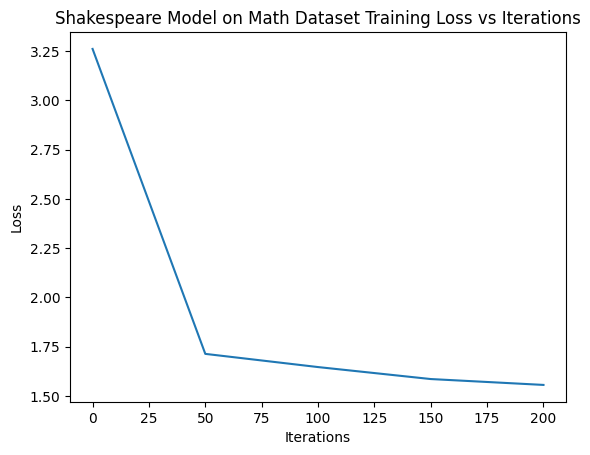

In [84]:
plot_losses(model_shakespeare_on_math_training_loss, "Shakespeare Model on Math Dataset Training Loss vs Iterations", 50)

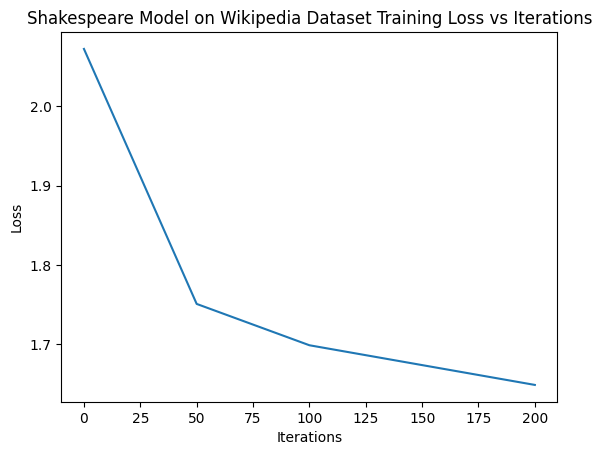

In [85]:
plot_losses(model_shakespeare_on_wikipedia_training_loss, "Shakespeare Model on Wikipedia Dataset Training Loss vs Iterations", 50)

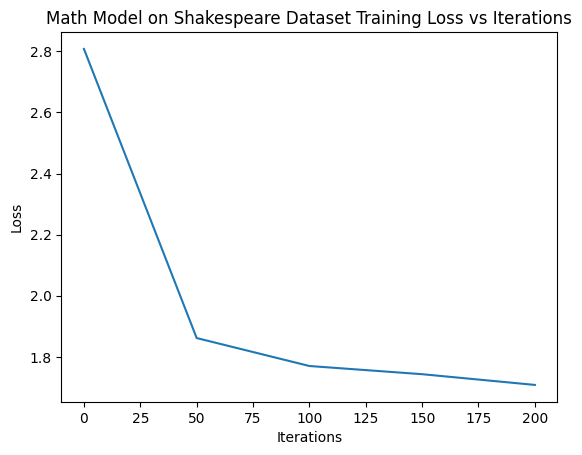

In [86]:
plot_losses(model_math_on_shakespeare_training_loss, "Math Model on Shakespeare Dataset Training Loss vs Iterations", 50)

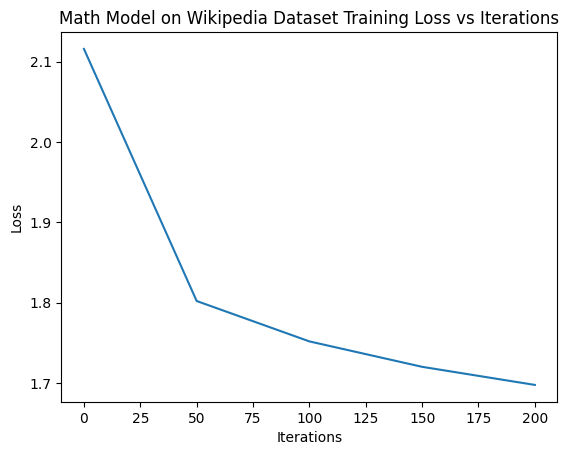

In [87]:
plot_losses(model_math_on_wikipedia_training_loss, "Math Model on Wikipedia Dataset Training Loss vs Iterations", 50)

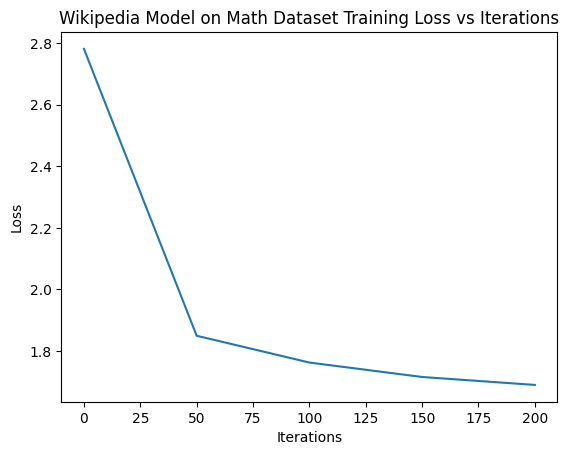

In [88]:
plot_losses(model_wikipedia_on_math_training_loss, "Wikipedia Model on Math Dataset Training Loss vs Iterations", 50)

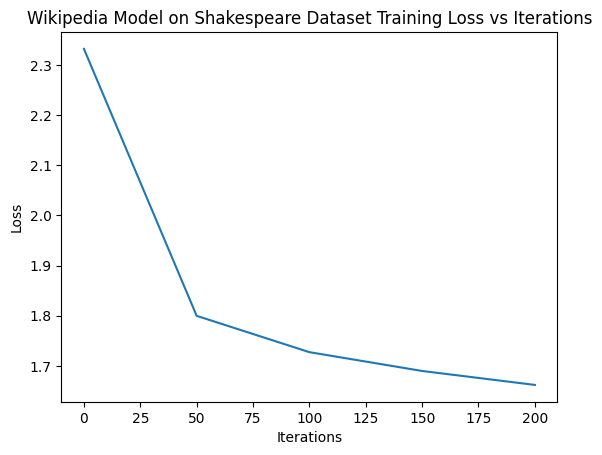

In [89]:
plot_losses(model_wikipedia_on_shakespeare_training_loss, "Wikipedia Model on Shakespeare Dataset Training Loss vs Iterations", 50)

## **Part 3 – Inspecting the Softmax Output Layer**

In this part, you will explore how the model’s **output probabilities** evolve during training for different prompts.

### **What to Do**

* Choose **several prompts** (at least 2–3) that differ in domain and style (e.g., math expressions, natural language, biology terms).
* For each prompt, extract at each checkpoint:

  * The **softmax probability distribution** over the vocabulary.
  * The **entropy** of the distribution (a measure of model confidence/uncertainty).
* Plot the **trajectories of top candidate tokens** over checkpoints for each prompt.

### **What to Look For**

* **Predictability & Hardening**

  * Does the distribution concentrate (one token dominates) as training progresses?
  * Are some prompts much more predictable than others?

* **Entropy & Uncertainty**

  * Compare entropy across prompts.
  * Do in-domain prompts (e.g., math-related text) produce sharper, lower-entropy distributions?
  * Do out-of-domain prompts produce flatter, high-entropy distributions?

* **Biases in Token Predictions**

  * Are certain tokens consistently high-probability regardless of prompt?
  * Do different prompts encourage different sets of top tokens?

### **What to Report**

* Provide **plots** for each prompt.
* Give a **written description** of what you observe:

  * Where do probabilities harden?
  * Where do they remain diffuse?
  * How does this match your expectations about the model’s training data?
* Discuss what your findings imply about the model’s **predictability and specialization**.


In [10]:
import torch
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def load_model(ckpt_path,  GPT):
    ckpt = torch.load(ckpt_path, map_location=device)
    config = type("GPTConfig", (), ckpt["config"])
    stoi, itos = ckpt["stoi"], ckpt["itos"]
    config.vocab_size = len(stoi)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    return model, stoi, itos

def inspect_softmax(model, prompt, stoi, itos, top_k=10):
    # pick a fallback index if <unk> not in vocab
    unk_idx = stoi.get("<unk>", next(iter(stoi.values())))

    x = torch.tensor([[stoi.get(c, unk_idx) for c in prompt]], dtype=torch.long)
    with torch.no_grad():
        probs = F.softmax(model(x)[0][:, -1, :], dim=-1).squeeze()
    entropy = -(probs * torch.log(probs + 1e-12)).sum().item()
    top_p, top_i = torch.topk(probs, top_k)
    return {
        "prompt": prompt,
        "entropy": entropy,
        "probs": [(itos[i.item()], p.item()) for i, p in zip(top_i, top_p)]
    }


In [95]:
shakespeare_prompt = '''PAULINA:
Good my lor'''
math_prompt = "What is the integ"
wikipedia_prompt = "The history of the moder"

wikipedia_checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia"
shakespeare_checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare"
math_checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/checkpoints/math"

In [96]:
def get_entropy_and_probs(checkpoint_dir, iterations_interval, max_iterations, prompt):
  iterations_no = 0
  entropy_dict = {}
  probs_dict = {}
  for i in range(max_iterations):
    checkpoint_path = os.path.join(checkpoint_dir, f"iter_{iterations_no}.pt")
    if not os.path.exists(checkpoint_path):
      break
    model, stoi, itos = load_model(checkpoint_path, GPT)
    result = inspect_softmax(model, prompt, stoi, itos)
    entropy_dict[iterations_no] = result["entropy"]
    probs_dict[iterations_no] = result['probs']
    print(f"Iteration no - {iterations_no} done")
    iterations_no += iterations_interval
  return entropy_dict, probs_dict

## In Domain Prompts

In [111]:
wikipedia_entropy_dict, wikipedia_probs_dict = get_entropy_and_probs(wikipedia_checkpoint_dir, 1000, 15, wikipedia_prompt)

number of parameters: 0.43M
Iteration no - 0 done
number of parameters: 0.43M
Iteration no - 1000 done
number of parameters: 0.43M
Iteration no - 2000 done
number of parameters: 0.43M
Iteration no - 3000 done
number of parameters: 0.43M
Iteration no - 4000 done
number of parameters: 0.43M
Iteration no - 5000 done
number of parameters: 0.43M
Iteration no - 6000 done
number of parameters: 0.43M
Iteration no - 7000 done
number of parameters: 0.43M
Iteration no - 8000 done
number of parameters: 0.43M
Iteration no - 9000 done
number of parameters: 0.43M
Iteration no - 10000 done
number of parameters: 0.43M
Iteration no - 11000 done
number of parameters: 0.43M
Iteration no - 12000 done
number of parameters: 0.43M
Iteration no - 13000 done
number of parameters: 0.43M
Iteration no - 14000 done


In [112]:
shakespeare_entropy_dict, shakespeare_probs_dict = get_entropy_and_probs(shakespeare_checkpoint_dir, 1000, 15, shakespeare_prompt)

number of parameters: 0.41M
Iteration no - 0 done
number of parameters: 0.41M
Iteration no - 1000 done
number of parameters: 0.41M
Iteration no - 2000 done
number of parameters: 0.41M
Iteration no - 3000 done
number of parameters: 0.41M
Iteration no - 4000 done
number of parameters: 0.41M
Iteration no - 5000 done
number of parameters: 0.41M
Iteration no - 6000 done
number of parameters: 0.41M
Iteration no - 7000 done
number of parameters: 0.41M
Iteration no - 8000 done
number of parameters: 0.41M
Iteration no - 9000 done
number of parameters: 0.41M
Iteration no - 10000 done
number of parameters: 0.41M
Iteration no - 11000 done
number of parameters: 0.41M
Iteration no - 12000 done
number of parameters: 0.41M
Iteration no - 13000 done
number of parameters: 0.41M
Iteration no - 14000 done


In [113]:
math_entropy_dict, math_probs_dict = get_entropy_and_probs(math_checkpoint_dir, 1000, 15, math_prompt)

number of parameters: 0.41M
Iteration no - 0 done
number of parameters: 0.41M
Iteration no - 1000 done
number of parameters: 0.41M
Iteration no - 2000 done
number of parameters: 0.41M
Iteration no - 3000 done
number of parameters: 0.41M
Iteration no - 4000 done
number of parameters: 0.41M
Iteration no - 5000 done
number of parameters: 0.41M
Iteration no - 6000 done
number of parameters: 0.41M
Iteration no - 7000 done
number of parameters: 0.41M
Iteration no - 8000 done
number of parameters: 0.41M
Iteration no - 9000 done
number of parameters: 0.41M
Iteration no - 10000 done
number of parameters: 0.41M
Iteration no - 11000 done
number of parameters: 0.41M
Iteration no - 12000 done
number of parameters: 0.41M
Iteration no - 13000 done
number of parameters: 0.41M
Iteration no - 14000 done


In [100]:
#Plot entropy vs interations
def plot_entropy(entropy_dict, title):
  iterations = [key for key in entropy_dict.keys()]
  entropies = entropy_dict.values()
  plt.figure(figsize=(12, 6))
  plt.plot(iterations, entropies)
  plt.xlabel('Iterations')
  plt.ylabel('Entropy')
  plt.title(title)
  plt.show()

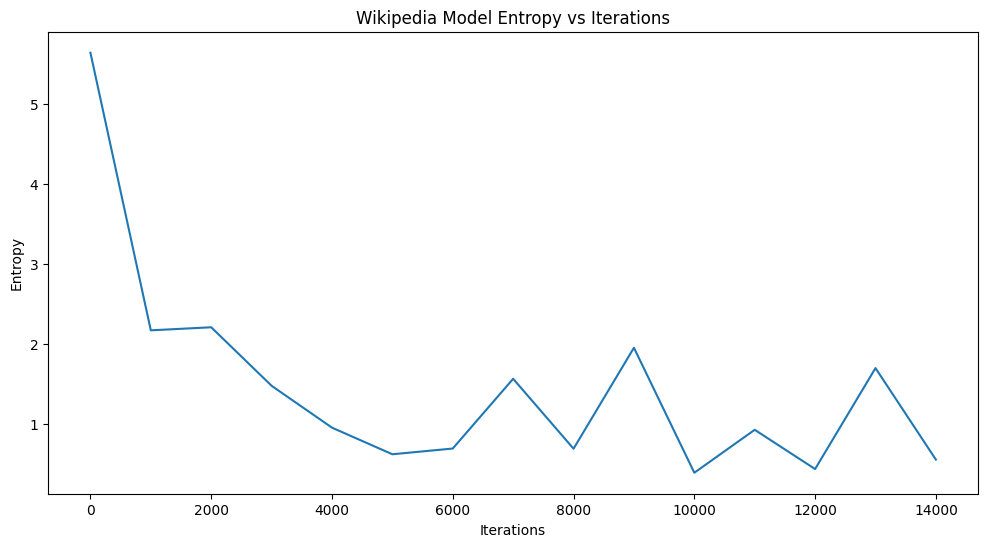

In [117]:
plot_entropy(wikipedia_entropy_dict, "Wikipedia Model Entropy vs Iterations")

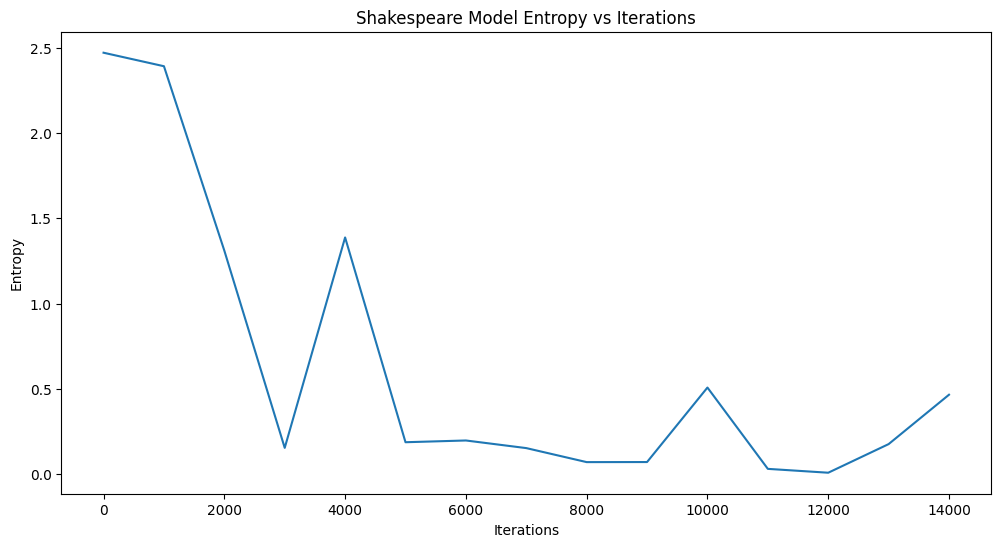

In [118]:
plot_entropy(shakespeare_entropy_dict, "Shakespeare Model Entropy vs Iterations")

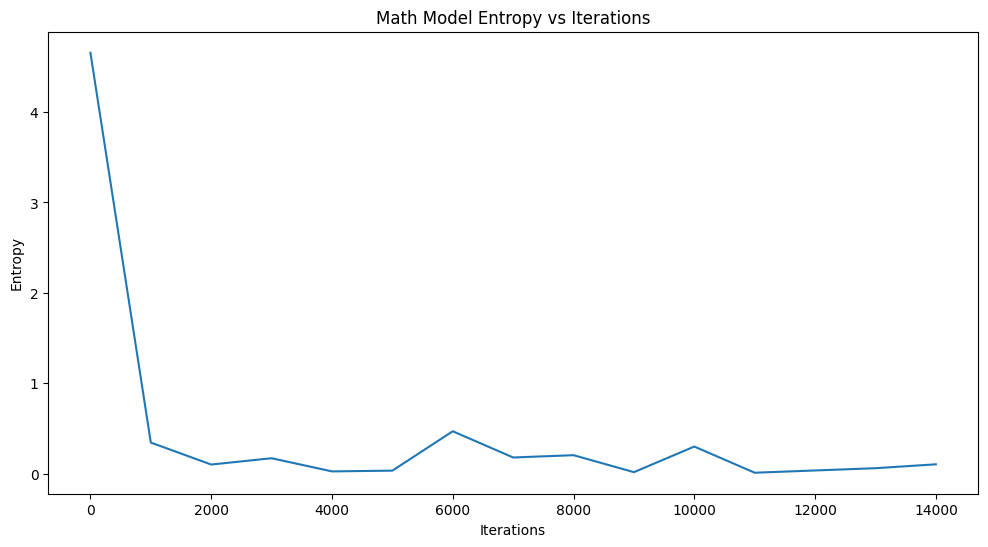

In [119]:
plot_entropy(math_entropy_dict, "Math Model Entropy vs Iterations")

In [107]:
def plot_checkpoint_probs(probs_dict, title, top_k=10):
    iterations = list(probs_dict.keys())

    tokens = set()
    for probs in probs_dict.values():
        tokens.update([t for t, _ in probs[:top_k]])
    tokens = list(tokens)

    token_prob_dict = {t: [] for t in tokens}
    for probs in probs_dict.values():
        prob_dict = dict(probs)
        for t in tokens:
            token_prob_dict[t].append(prob_dict.get(t, 0.0))

    cmap = plt.cm.get_cmap("tab20", len(tokens))
    colors = {t: cmap(i) for i, t in enumerate(tokens)}

    plt.figure(figsize=(12, 6))
    for t, probs in token_prob_dict.items():
        plt.plot(iterations, probs, marker='o', label=repr(t), color=colors[t])

    plt.title(title)
    plt.xlabel("Training Iteration")
    plt.ylabel("Probability")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()


/tmp/ipython-input-3913794842.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(tokens))  # tab20 gives 20 distinct colors (will cycle if >20)


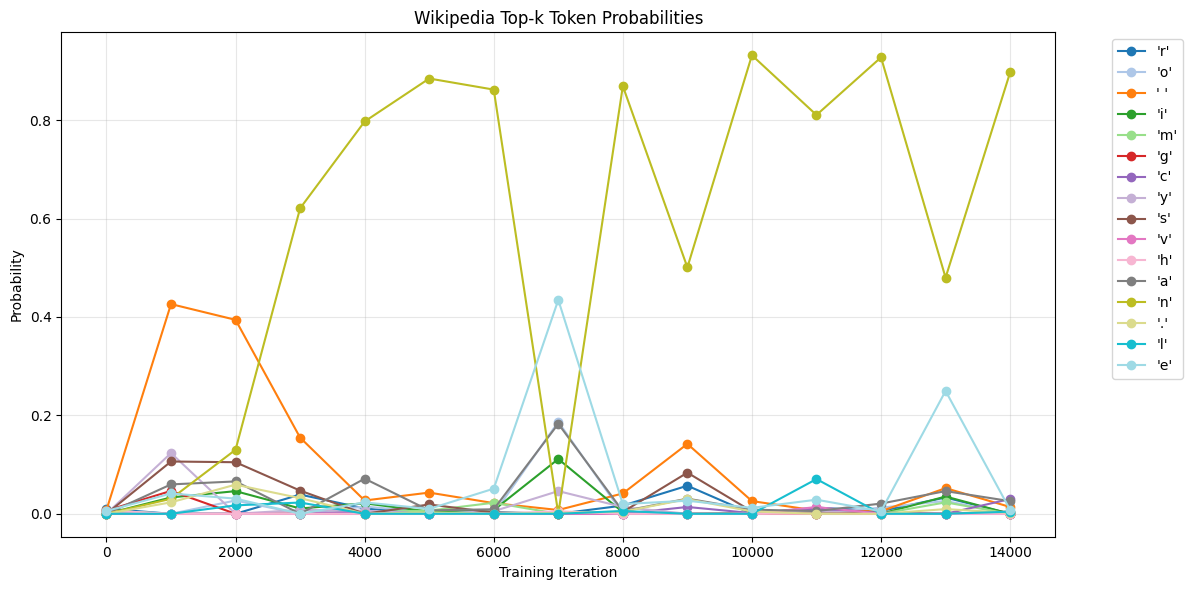

In [114]:
plot_checkpoint_probs(wikipedia_probs_dict, "Wikipedia Top-k Token Probabilities", top_k=5)

/tmp/ipython-input-3913794842.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(tokens))  # tab20 gives 20 distinct colors (will cycle if >20)


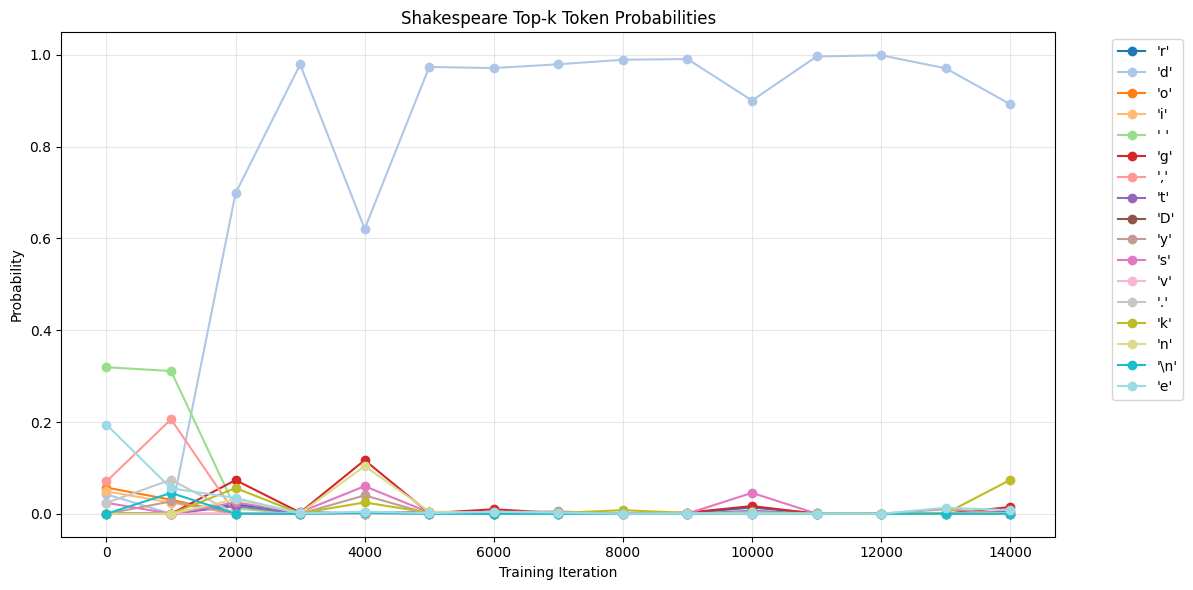

In [115]:
plot_checkpoint_probs(shakespeare_probs_dict, "Shakespeare Top-k Token Probabilities", top_k=5)

/tmp/ipython-input-3913794842.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(tokens))  # tab20 gives 20 distinct colors (will cycle if >20)


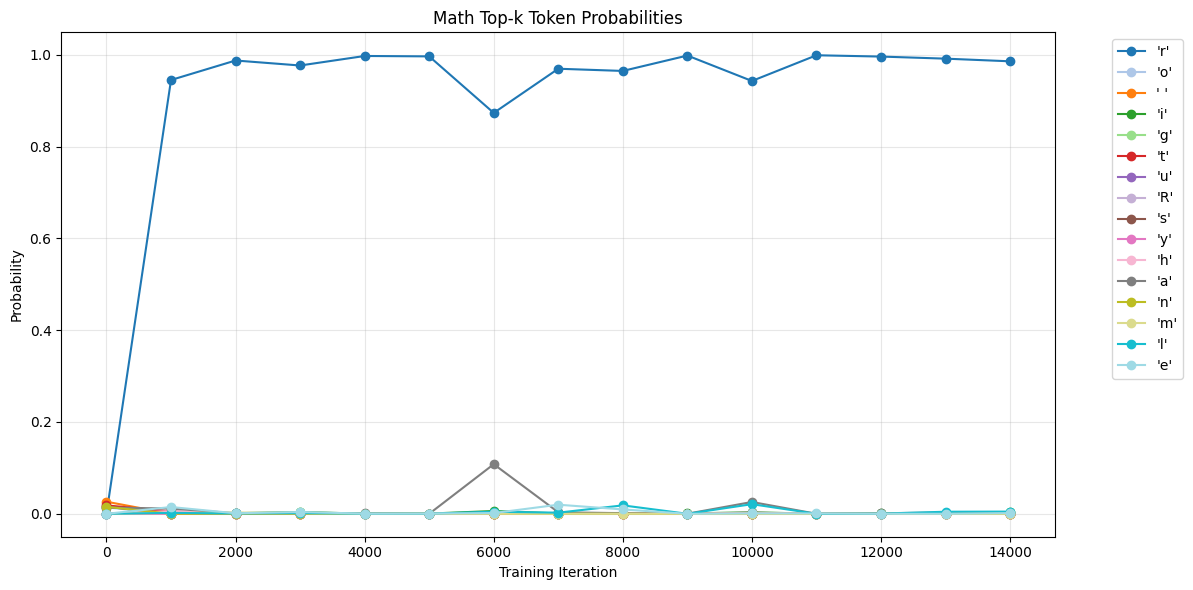

In [116]:
plot_checkpoint_probs(math_probs_dict, "Math Top-k Token Probabilities", top_k=5)

## Out of Domain Prompts

In [120]:
out_domain_wikipedia_entropy_dict, out_domain_wikipedia_probs_dict = get_entropy_and_probs(wikipedia_checkpoint_dir, 1000, 15, shakespeare_prompt)

number of parameters: 0.43M
Iteration no - 0 done
number of parameters: 0.43M
Iteration no - 1000 done
number of parameters: 0.43M
Iteration no - 2000 done
number of parameters: 0.43M
Iteration no - 3000 done
number of parameters: 0.43M
Iteration no - 4000 done
number of parameters: 0.43M
Iteration no - 5000 done
number of parameters: 0.43M
Iteration no - 6000 done
number of parameters: 0.43M
Iteration no - 7000 done
number of parameters: 0.43M
Iteration no - 8000 done
number of parameters: 0.43M
Iteration no - 9000 done
number of parameters: 0.43M
Iteration no - 10000 done
number of parameters: 0.43M
Iteration no - 11000 done
number of parameters: 0.43M
Iteration no - 12000 done
number of parameters: 0.43M
Iteration no - 13000 done
number of parameters: 0.43M
Iteration no - 14000 done


In [121]:
out_domain_shakespeare_entropy_dict, out_domain_shakespeare_probs_dict = get_entropy_and_probs(shakespeare_checkpoint_dir, 1000, 15, math_prompt)

number of parameters: 0.41M
Iteration no - 0 done
number of parameters: 0.41M
Iteration no - 1000 done
number of parameters: 0.41M
Iteration no - 2000 done
number of parameters: 0.41M
Iteration no - 3000 done
number of parameters: 0.41M
Iteration no - 4000 done
number of parameters: 0.41M
Iteration no - 5000 done
number of parameters: 0.41M
Iteration no - 6000 done
number of parameters: 0.41M
Iteration no - 7000 done
number of parameters: 0.41M
Iteration no - 8000 done
number of parameters: 0.41M
Iteration no - 9000 done
number of parameters: 0.41M
Iteration no - 10000 done
number of parameters: 0.41M
Iteration no - 11000 done
number of parameters: 0.41M
Iteration no - 12000 done
number of parameters: 0.41M
Iteration no - 13000 done
number of parameters: 0.41M
Iteration no - 14000 done


In [122]:
out_domain_math_entropy_dict, out_domain_math_probs_dict = get_entropy_and_probs(math_checkpoint_dir, 1000, 15, wikipedia_prompt)

number of parameters: 0.41M
Iteration no - 0 done
number of parameters: 0.41M
Iteration no - 1000 done
number of parameters: 0.41M
Iteration no - 2000 done
number of parameters: 0.41M
Iteration no - 3000 done
number of parameters: 0.41M
Iteration no - 4000 done
number of parameters: 0.41M
Iteration no - 5000 done
number of parameters: 0.41M
Iteration no - 6000 done
number of parameters: 0.41M
Iteration no - 7000 done
number of parameters: 0.41M
Iteration no - 8000 done
number of parameters: 0.41M
Iteration no - 9000 done
number of parameters: 0.41M
Iteration no - 10000 done
number of parameters: 0.41M
Iteration no - 11000 done
number of parameters: 0.41M
Iteration no - 12000 done
number of parameters: 0.41M
Iteration no - 13000 done
number of parameters: 0.41M
Iteration no - 14000 done


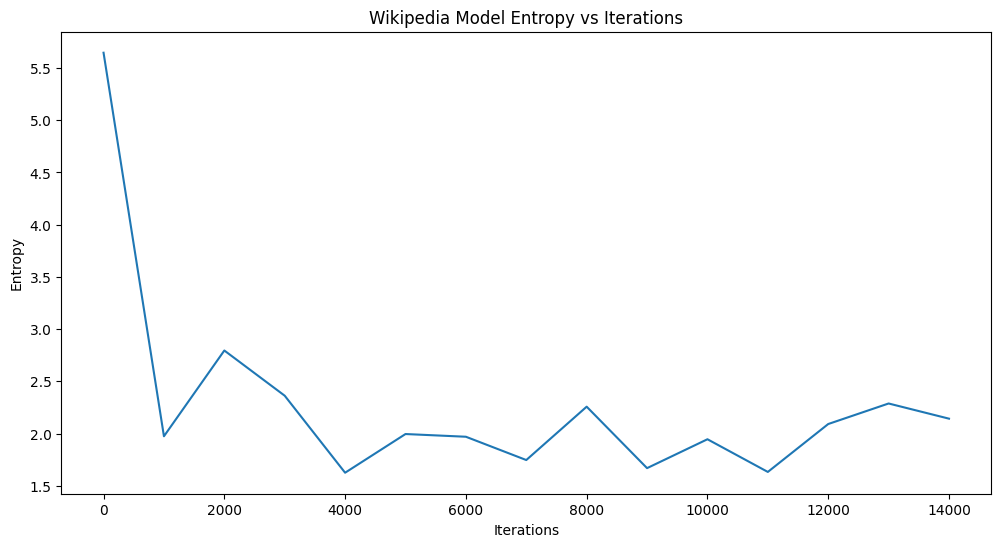

In [123]:
plot_entropy(out_domain_wikipedia_entropy_dict, "Wikipedia Model Entropy vs Iterations")

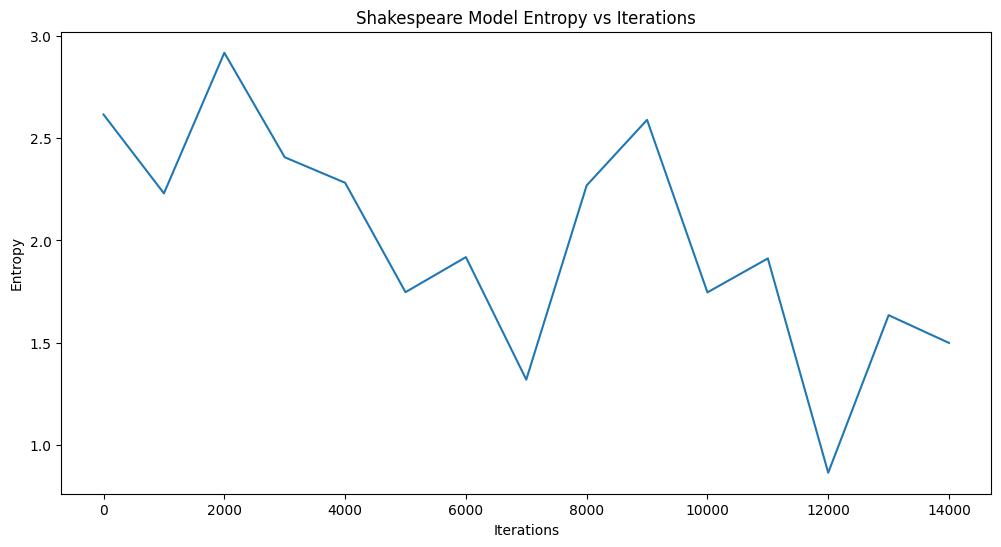

In [124]:
plot_entropy(out_domain_shakespeare_entropy_dict, "Shakespeare Model Entropy vs Iterations")

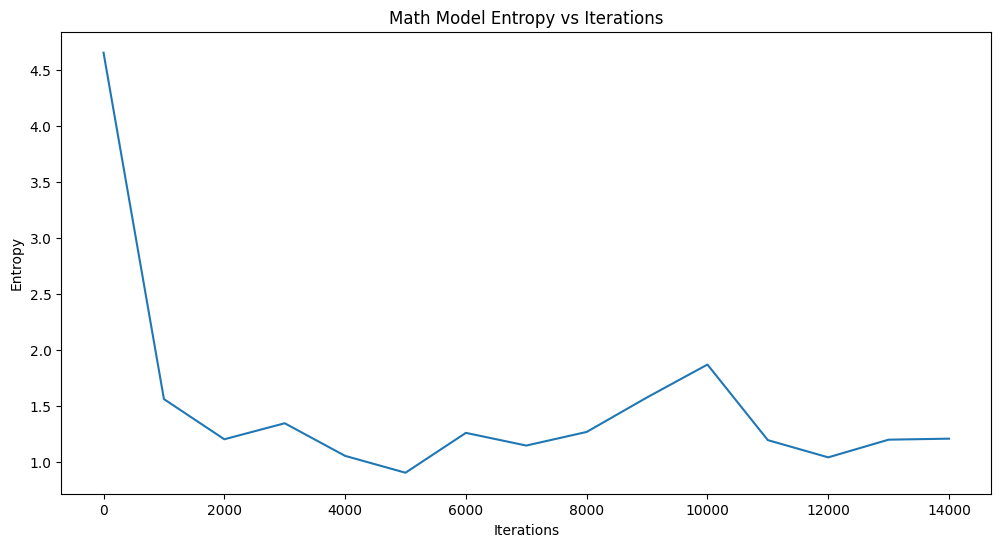

In [125]:
plot_entropy(out_domain_math_entropy_dict, "Math Model Entropy vs Iterations")

/tmp/ipython-input-3913794842.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(tokens))  # tab20 gives 20 distinct colors (will cycle if >20)
/tmp/ipython-input-3913794842.py:30: UserWarning: Glyph 23477 (\N{CJK UNIFIED IDEOGRAPH-5BB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23477 (\N{CJK UNIFIED IDEOGRAPH-5BB5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


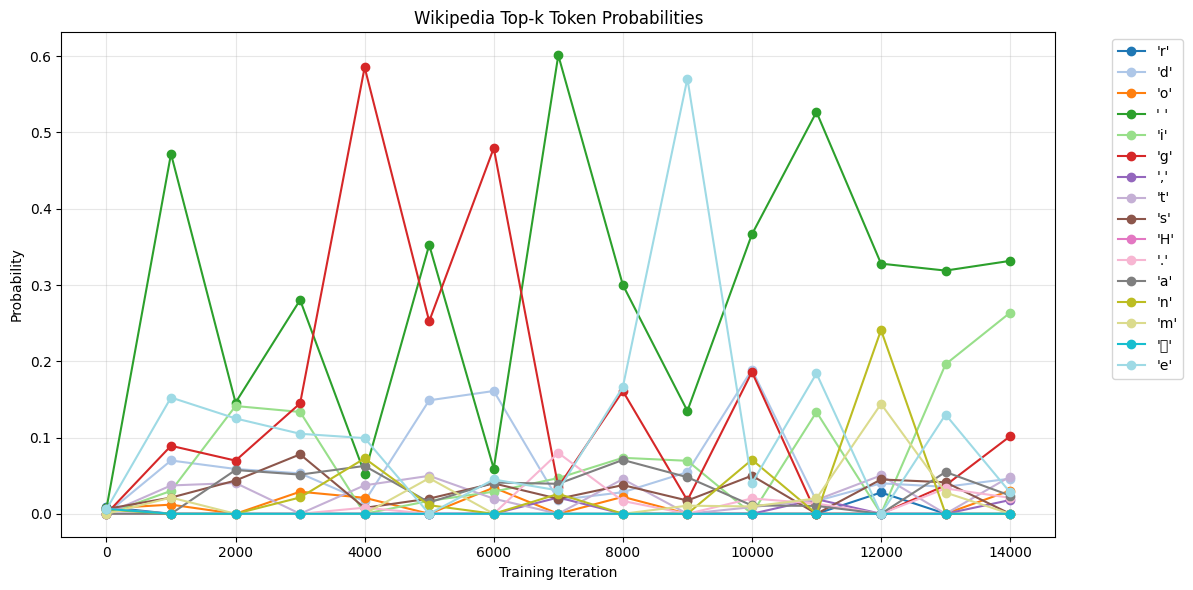

In [126]:
plot_checkpoint_probs(out_domain_wikipedia_probs_dict, "Wikipedia Top-k Token Probabilities", top_k=5)

/tmp/ipython-input-3913794842.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(tokens))  # tab20 gives 20 distinct colors (will cycle if >20)


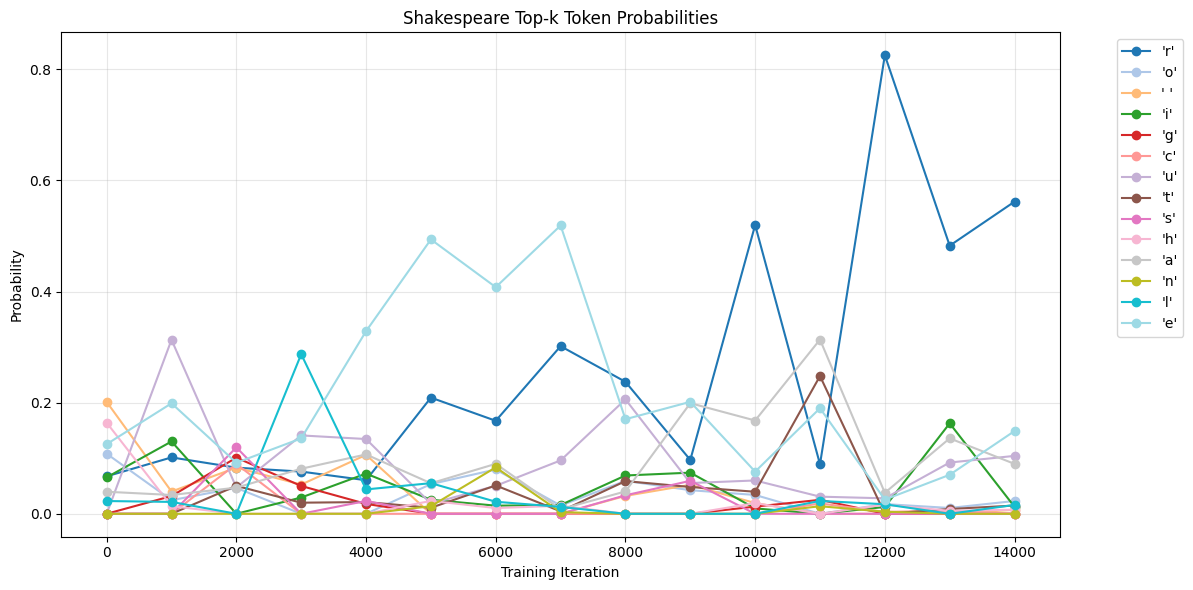

In [127]:
plot_checkpoint_probs(out_domain_shakespeare_probs_dict, "Shakespeare Top-k Token Probabilities", top_k=5)

/tmp/ipython-input-3913794842.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(tokens))  # tab20 gives 20 distinct colors (will cycle if >20)


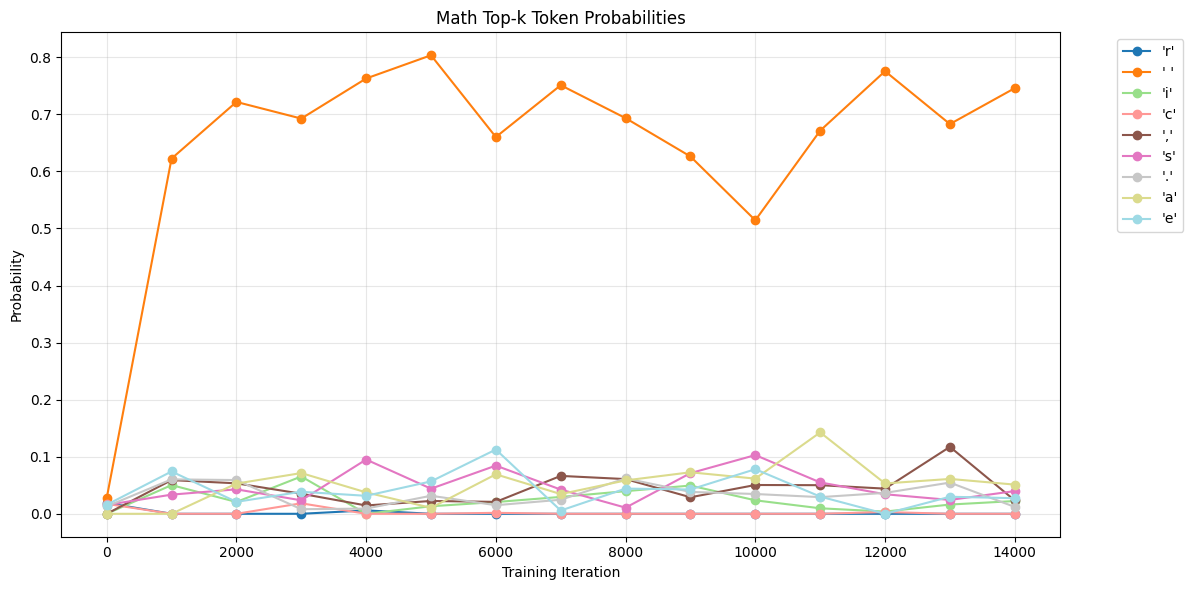

In [128]:
plot_checkpoint_probs(out_domain_math_probs_dict, "Math Top-k Token Probabilities", top_k=5)


## **Part 4 – Grad-CAM for Language Models**

In this part, you’ll build a lightweight version of *Grad-CAM* for a language model. Instead of visualizing gradients in images, we’ll look at how gradients flow into **token embeddings** to measure which input tokens most affect a model’s probability of generating a target token.

### **Steps**

1. **Compute gradients**

   * Use the provided `token_gradients` function.
   * This function backpropagates from the probability of a **target token** (e.g., `"e"`) back to the input embeddings.
   * For each input token, it returns the gradient norm, which indicates **how much changing that token would affect the prediction**.

2. **Experiment with checkpoints**

   * Run the method across checkpoints of your trained model (e.g., every 100 iterations).
   * Track how gradient importance changes over time.
   * Try different prompts and different target tokens.

3. **Compare across models**

   * Run the same analysis on domain-trained models (e.g., trained on Wikipedia vs. math text).
   * Compare: Do the same tokens consistently drive predictions? Or do models in different domains “care” about different tokens?


### **Discussion Questions**

1. **Character influence:**
   Which characters consistently receive the highest gradient norms? Are they vowels, consonants, punctuation, or digits? Do frequent letters (like “e”) dominate, or do rare characters sometimes matter more?
2. **Checkpoint dynamics:**
   How does the distribution of influential tokens change as training progresses? Does the model become more focused or more diffuse?
3. **Domain differences:**
   Compare results from different domain-trained models. Do Wikipedia-trained models rely more on content words, while math-trained ones emphasize structure/symbols?
4. **Zero-shot vs few-shot:**
   If you add example completions to the prompt (few-shot), how does the gradient map shift compared to zero-shot?
5. **Interpretability limits:**
   What are the limitations of gradient-based methods? Do high gradient norms always mean high “importance”? When might this method be misleading?
  


In [6]:
import torch
import torch.nn.functional as F

import os
import matplotlib.pyplot as plt
import numpy as np

def token_gradients(model, prompt, target_token, stoi, itos ):
    """
    Compute gradient norms per input token wrt probability of `target_token`.
    """
    model.eval()
    x = torch.tensor([stoi[c] for c in prompt], dtype=torch.long)[None, :]

    grads = {}

    # Hook to capture embeddings with gradient
    def save_grad(module, inp, out):
        out.retain_grad()
        grads['emb'] = out

    handle = model.transformer.wte.register_forward_hook(save_grad)

    # Forward pass
    logits, _ = model(x)
    last_logits = logits[:, -1, :]   # [B, vocab]

    target_idx = stoi.get(target_token, None)
    if target_idx is None:
        raise ValueError(f"Token {target_token!r} not in vocab")

    probs = F.softmax(last_logits, dim=-1)
    target_prob = probs[0, target_idx]

    # Backprop
    model.zero_grad(set_to_none=True)
    target_prob.backward()

    # Now grads['emb'] has the embedding grads
    grad_norms = grads['emb'].grad[0].norm(dim=-1)  # [T]
    tokens = [itos[i.item()] for i in x[0]]

    # Clean up the hook
    handle.remove()

    return list(zip(tokens, grad_norms.tolist()))



In [7]:
wikipedia_checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/checkpoints/wikipedia"
shakespeare_checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/checkpoints/shakespeare"
math_checkpoint_dir = "/content/drive/MyDrive/DSF/Lab1/checkpoints/math"


iteration_interval = 100
max_iterations = 40

In [8]:
def plot_gradcam_results(result_dict, title=None, top_k=5):
    for prompt, iter_data in result_dict.items():
        iterations = sorted(iter_data.keys())

        token_set = set()
        for result in iter_data.values():
            token_set.update([t for t, _ in result])
        tokens = list(token_set)

        token_grad_dict = {t: [] for t in tokens}
        for it in iterations:
            grad_dict = dict(iter_data[it])
            for t in tokens:
                token_grad_dict[t].append(grad_dict.get(t, 0.0))

        sorted_tokens = tokens
        plt.figure(figsize=(12, 6))
        cmap = plt.cm.get_cmap("tab20", len(sorted_tokens))
        colors = {t: cmap(i) for i, t in enumerate(sorted_tokens)}

        for t in sorted_tokens:
            plt.plot(iterations, token_grad_dict[t], marker='o', label=repr(t), color=colors[t])

        plt.title(f"{title or 'Grad-CAM'}\nPrompt: {repr(prompt)}")
        plt.xlabel("Training Iteration")
        plt.ylabel("Gradient Norm")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.grid(alpha=0.3)
        plt.show()

In [19]:
wikipedia_result_dict = {}
wikipedia_prompts_list = [("The history of the moder", "n"), ("The soft skill becomes impo", "r"), ("Telephone was inven", "t"), ("The spacecraft reentered Earth's atmosphere at ~7.8 ", "k")]
for prompt, target_token in wikipedia_prompts_list:
  prompt_specific_result = {}
  iteration_no = 0
  for i in range(max_iterations):
    checkpoint_path = os.path.join(wikipedia_checkpoint_dir, f"iter_{iteration_no}.pt")
    if not os.path.exists(checkpoint_path):
      break
    model, stoi, itos = load_model(checkpoint_path, GPT)
    wikipedia_result = token_gradients(model, prompt, target_token, stoi, itos)
    prompt_specific_result[iteration_no] = wikipedia_result
    print(f"Iteration no - {iteration_no} done")
    iteration_no += iteration_interval
  wikipedia_result_dict[prompt] = prompt_specific_result
  print(f"Done for {prompt}")



number of parameters: 0.43M
Iteration no - 0 done
number of parameters: 0.43M
Iteration no - 100 done
number of parameters: 0.43M
Iteration no - 200 done
number of parameters: 0.43M
Iteration no - 300 done
number of parameters: 0.43M
Iteration no - 400 done
number of parameters: 0.43M
Iteration no - 500 done
number of parameters: 0.43M
Iteration no - 600 done
number of parameters: 0.43M
Iteration no - 700 done
number of parameters: 0.43M
Iteration no - 800 done
number of parameters: 0.43M
Iteration no - 900 done
number of parameters: 0.43M
Iteration no - 1000 done
number of parameters: 0.43M
Iteration no - 1100 done
number of parameters: 0.43M
Iteration no - 1200 done
number of parameters: 0.43M
Iteration no - 1300 done
number of parameters: 0.43M
Iteration no - 1400 done
number of parameters: 0.43M
Iteration no - 1500 done
number of parameters: 0.43M
Iteration no - 1600 done
number of parameters: 0.43M
Iteration no - 1700 done
number of parameters: 0.43M
Iteration no - 1800 done
numbe

/tmp/ipython-input-1014494327.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(sorted_tokens))


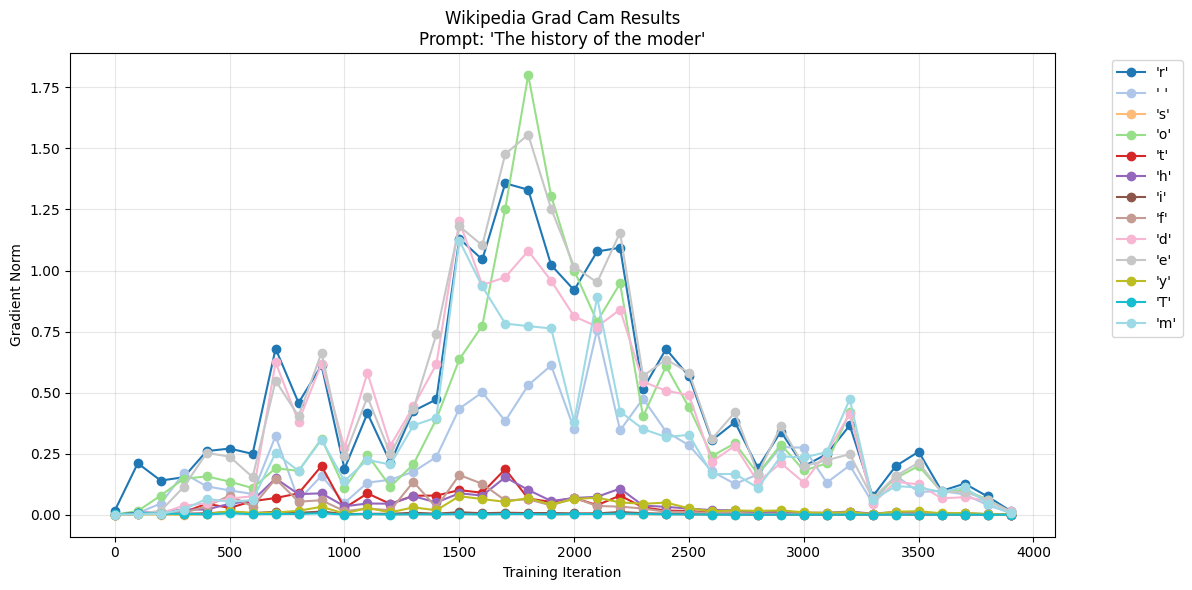

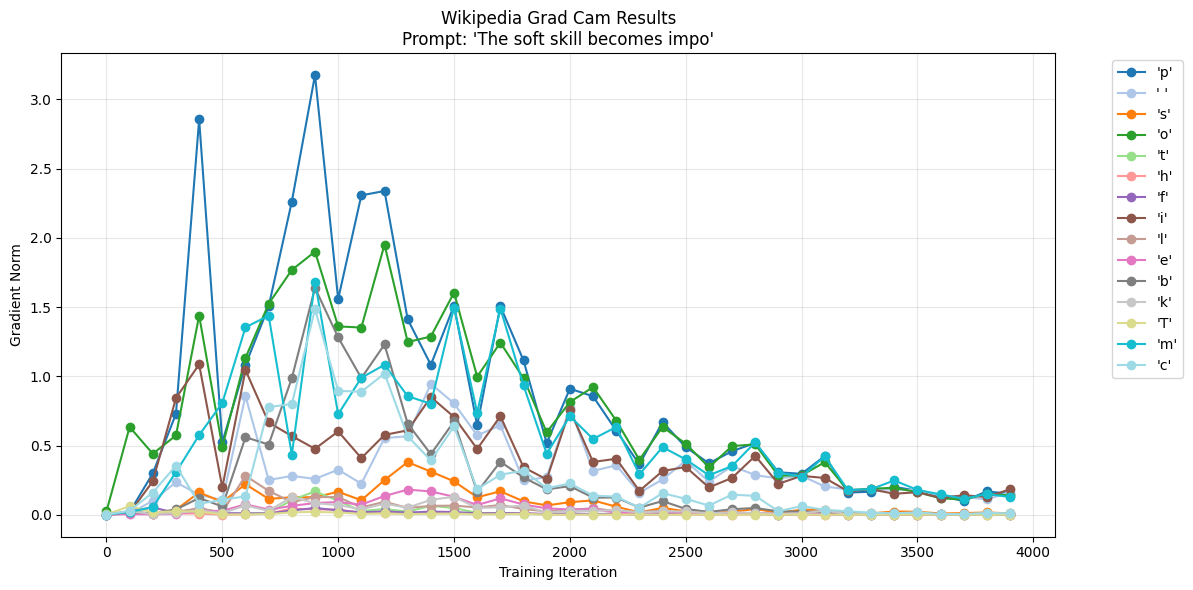

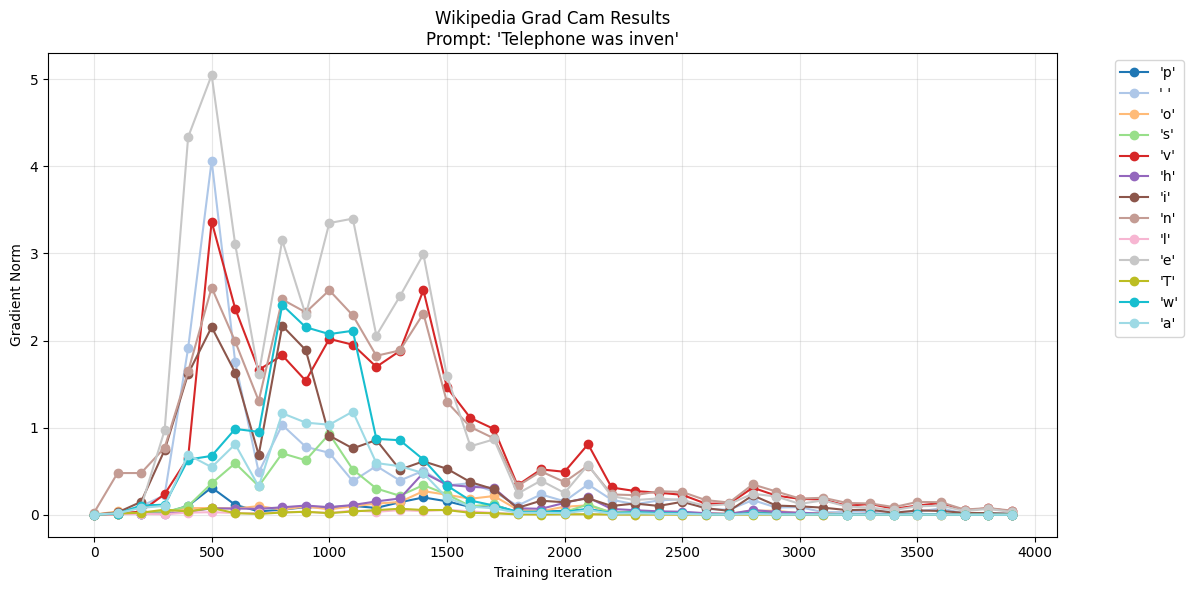

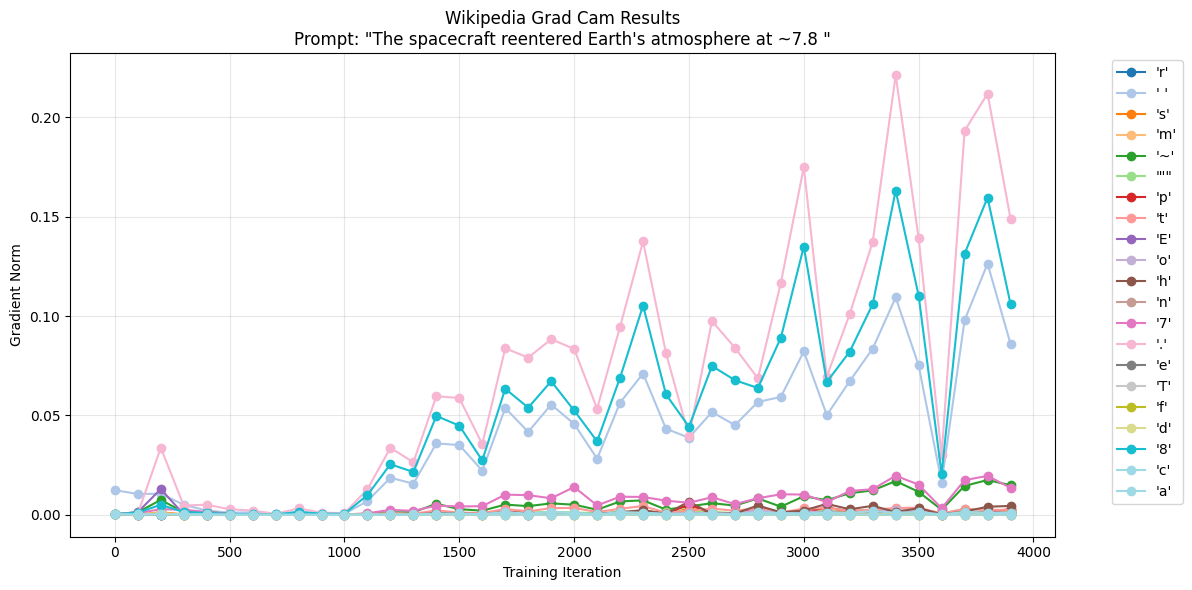

In [20]:
plot_gradcam_results(wikipedia_result_dict, "Wikipedia Grad Cam Results")

In [17]:
shakespeare_result_dict = {}
shakespeare_prompts_list = [('''LUCENTIO:
Basta; content thee, for I ha''', "v"), ('''LADY ANNE:
No farther than the Tower''', ";"), ('''JQUEEN ELIZABETH:
O Dorset, speak not to me, get the''', "e")]
for prompt, target_token in shakespeare_prompts_list:
  prompt_specific_result = {}
  iteration_no = 0
  for i in range(max_iterations):
    checkpoint_path = os.path.join(shakespeare_checkpoint_dir, f"iter_{iteration_no}.pt")
    if not os.path.exists(checkpoint_path):
      break
    model, stoi, itos = load_model(checkpoint_path, GPT)
    shakespeare_result = token_gradients(model, prompt, target_token, stoi, itos)
    prompt_specific_result[iteration_no] = shakespeare_result
    print(f"Iteration no - {iteration_no} done")
    iteration_no += iteration_interval
  shakespeare_result_dict[prompt] = prompt_specific_result
  print(f"Done for {prompt}")



number of parameters: 0.41M
Iteration no - 0 done
number of parameters: 0.41M
Iteration no - 100 done
number of parameters: 0.41M
Iteration no - 200 done
number of parameters: 0.41M
Iteration no - 300 done
number of parameters: 0.41M
Iteration no - 400 done
number of parameters: 0.41M
Iteration no - 500 done
number of parameters: 0.41M
Iteration no - 600 done
number of parameters: 0.41M
Iteration no - 700 done
number of parameters: 0.41M
Iteration no - 800 done
number of parameters: 0.41M
Iteration no - 900 done
number of parameters: 0.41M
Iteration no - 1000 done
number of parameters: 0.41M
Iteration no - 1100 done
number of parameters: 0.41M
Iteration no - 1200 done
number of parameters: 0.41M
Iteration no - 1300 done
number of parameters: 0.41M
Iteration no - 1400 done
number of parameters: 0.41M
Iteration no - 1500 done
number of parameters: 0.41M
Iteration no - 1600 done
number of parameters: 0.41M
Iteration no - 1700 done
number of parameters: 0.41M
Iteration no - 1800 done
numbe

/tmp/ipython-input-1014494327.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(sorted_tokens))


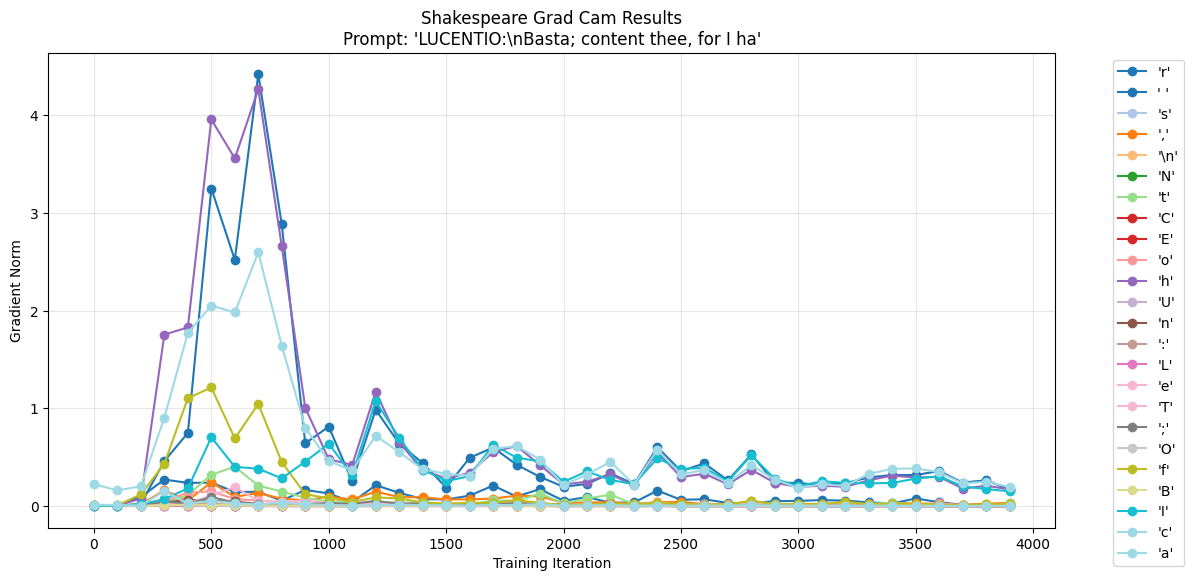

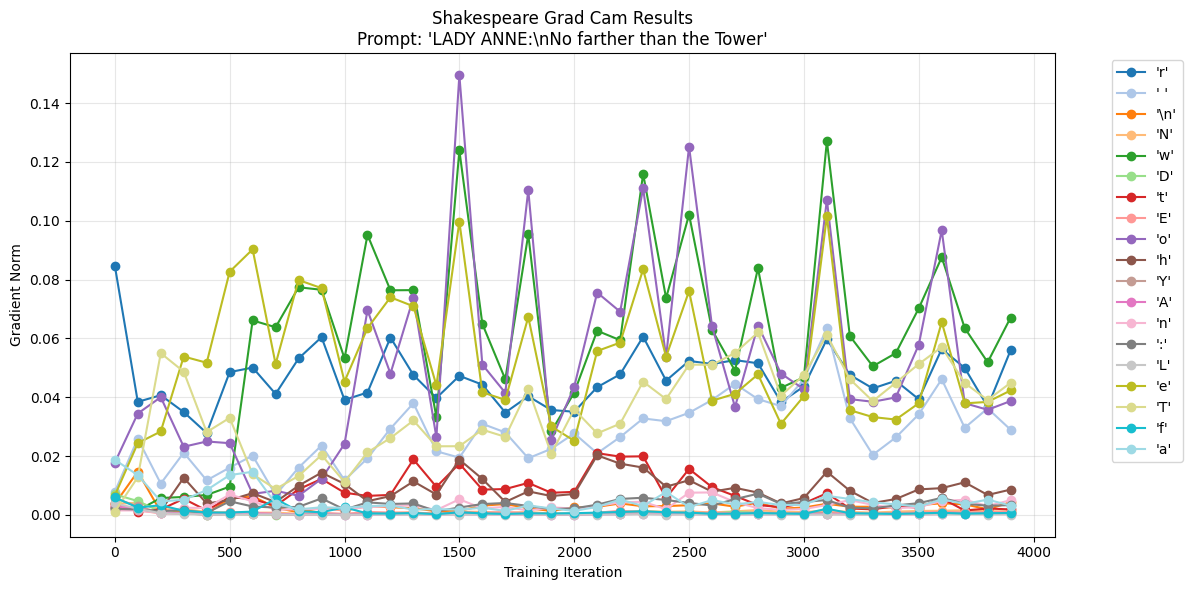

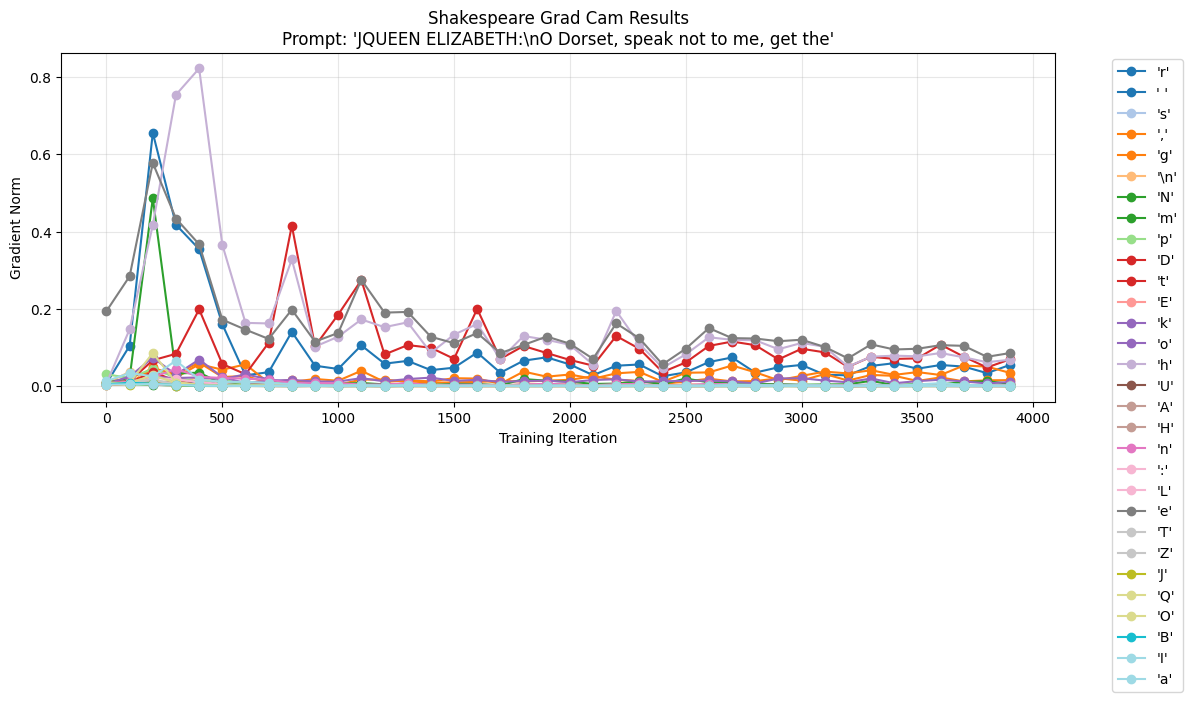

In [18]:
plot_gradcam_results(shakespeare_result_dict, "Shakespeare Grad Cam Results")

In [167]:
math_result_dict = {}
math_prompts_list = [("Show that the quadratic mean of the func", "t"), ('''From p. 38, we have,
d(ux) = ud''', "x"), ('''FINDING AREAS BY INTEGRATING 213

Now reckon out the are''', "a")]
for prompt, target_token in math_prompts_list:
  prompt_specific_result = {}
  iteration_no = 0
  for i in range(max_iterations):
    checkpoint_path = os.path.join(math_checkpoint_dir, f"iter_{iteration_no}.pt")
    if not os.path.exists(checkpoint_path):
      break
    model, stoi, itos = load_model(checkpoint_path, GPT)
    math_result = token_gradients(model, prompt, target_token, stoi, itos)
    prompt_specific_result[iteration_no] = math_result
    print(f"Iteration no - {iteration_no} done")
    iteration_no += iteration_interval
  math_result_dict[prompt] = prompt_specific_result
  print(f"Done for {prompt}")



number of parameters: 0.41M
Iteration no - 0 done
number of parameters: 0.41M
Iteration no - 100 done
number of parameters: 0.41M
Iteration no - 200 done
number of parameters: 0.41M
Iteration no - 300 done
number of parameters: 0.41M
Iteration no - 400 done
number of parameters: 0.41M
Iteration no - 500 done
number of parameters: 0.41M
Iteration no - 600 done
number of parameters: 0.41M
Iteration no - 700 done
number of parameters: 0.41M
Iteration no - 800 done
number of parameters: 0.41M
Iteration no - 900 done
number of parameters: 0.41M
Iteration no - 1000 done
number of parameters: 0.41M
Iteration no - 1100 done
number of parameters: 0.41M
Iteration no - 1200 done
number of parameters: 0.41M
Iteration no - 1300 done
number of parameters: 0.41M
Iteration no - 1400 done
number of parameters: 0.41M
Iteration no - 1500 done
number of parameters: 0.41M
Iteration no - 1600 done
number of parameters: 0.41M
Iteration no - 1700 done
number of parameters: 0.41M
Iteration no - 1800 done
numbe

/tmp/ipython-input-1960651286.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(sorted_tokens))


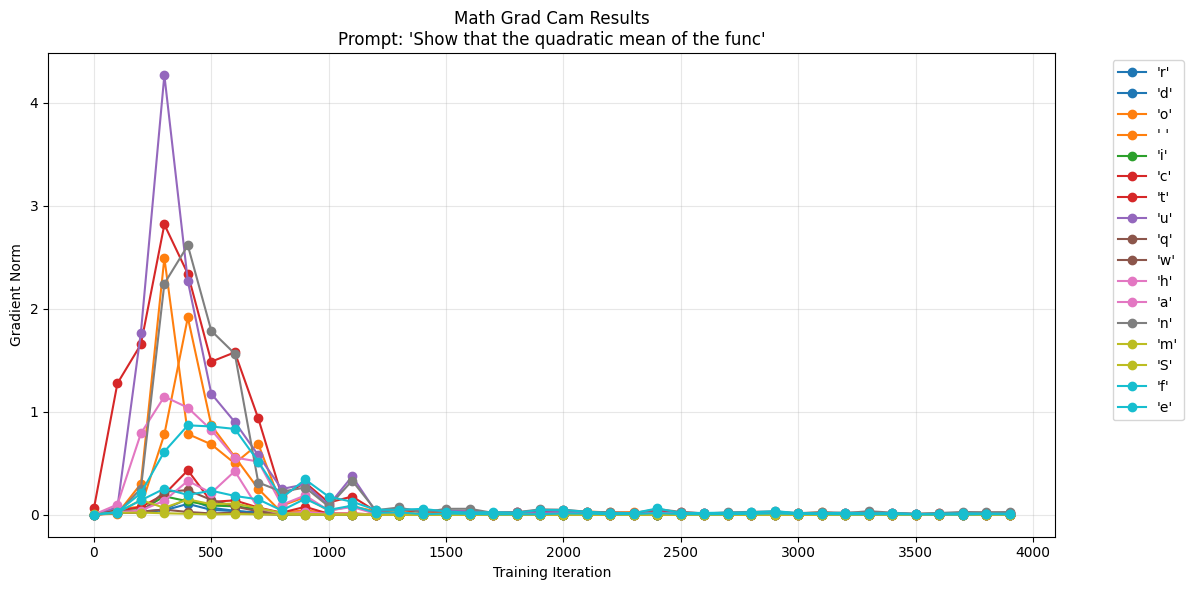

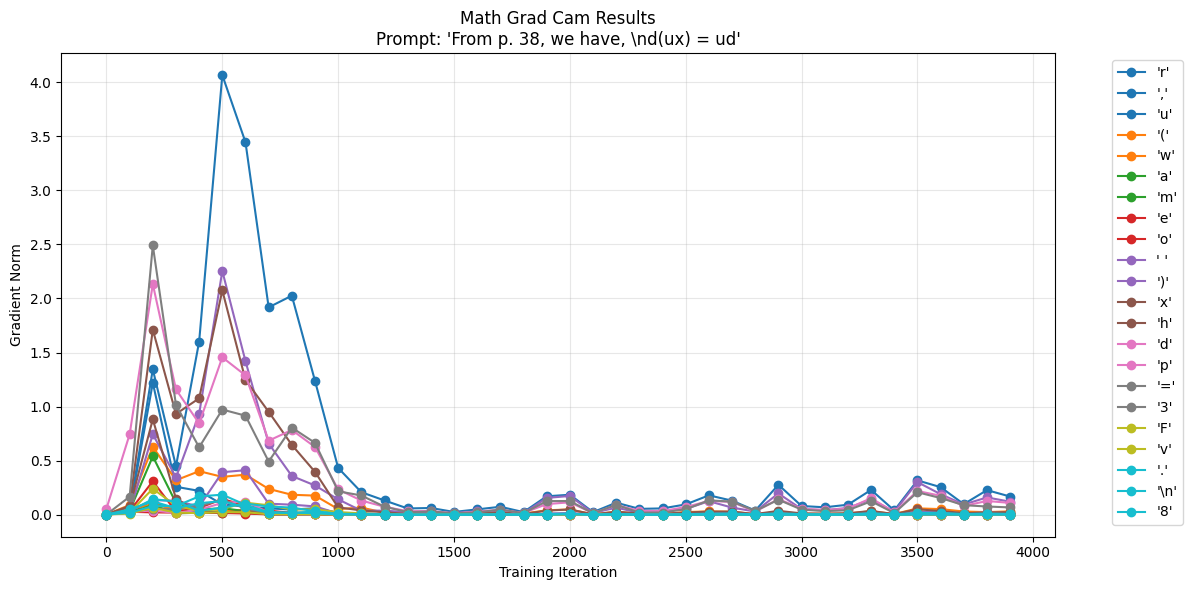

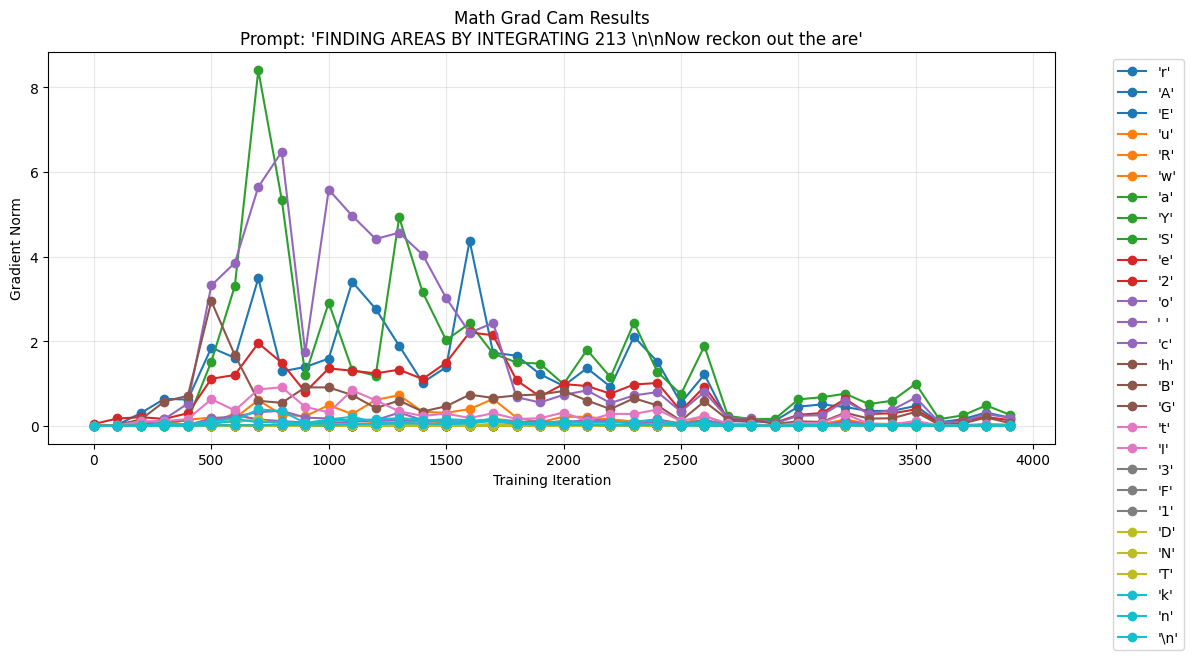

In [174]:
plot_gradcam_results(math_result_dict, "Math Grad Cam Results")